# Complete Beginner's guide to top 3%

In the following notebook i have tried to give information about:
* intuition behind EDA practices undertaken in notebook.
* Various traps that beginners should be aware of.
* Comprehensive model hyper parameter tuning guideline.
* Stacking

In [1]:
!pip install seaborn==0.11.0 # upgrading seaborn library to use newer plots and features!!

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
Invalid requirement: '#'



In [2]:
# libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Encoders
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder

# Strategic imports
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Machine learning Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, VotingClassifier

from tensorflow import keras
import tensorflow as tf

# imports to mute warnings
pd.options.display.max_rows=200
pd.set_option('mode.chained_assignment', None)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=RuntimeWarning)

sns.__version__

'0.11.0'

In [3]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [4]:
train = pd.read_csv('../../Data/train.csv', index_col='PassengerId')
test = pd.read_csv('../../Data/test.csv', index_col='PassengerId')

**Small Note before we start:**

There are a lot of excellent EDA kernels, but few of them combine training and test set to perform EDA, for the given dataset i do not think it is as big of a deal(why i think so, i will explain at the end) as it should be, you should never combine train and test set!! titanic dataset is the starting point of many individuals in the field of data science and looking at this practice can make it very easy for beginners to develop the habit of peeking into the test set, i would go as far as saying that once you have separated test and training sets you should consider test set as something that you will get in future once you have trained the best model as per training data, consider it as something which is only given to you when you are to make final predictions.

Now why do i think it is not too bad to do so, reason is that... if we look at it from competition point of view, using the test data to extract information which can be helpful to make it easier for making predictions on test data and boost your raking is plausible, Given that titanic dataset is something which will always stay of the same size, that is no new out of sample data will be generated , such practice can help boost score. But it is deterimental for beginners to see such practice in action, developing the habit to combine test and train datasets is easy, the pros who do it in there kernels already now the implications, but a beginner does not. So i wanted to just point this out before you begin going through the kernel, We have avoided combining test and training dataset in EDA, but we will be combining them to derive the Ticket_frequency feature, i will try to give a plausible explanation for the same when we create that feature in Feature engineering section, But lets say if data set was not of same size for eternity, we will not create Ticket frequency feature if peeking at the test data was the only option!!


# Exploratory Data Analysis



## Missing value imputation

For beginners EDA becomes quite an overwhelming task, sometimes it may even be difficult to take the first step, you just don't know where to start and how to ask questions to your data!! My advice is to just start with plotting the relationship of continuous and categorical features with the target. If you have a continuous variable, look at its ditribution to find if it is skewed or not.


While imputing missing values it is always beneficial to perform a correlation check and see which features correlate well with the feature we wish to impute, then you may make some visualizations to better understand the way you should impute the data.

In [5]:
train.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
test.isna().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

So we only have missing values in Age, Cabin for both train and test, Embarked and Fare have missing values for train and test respectively, we can impute them simply using median or mean of the whole feature.

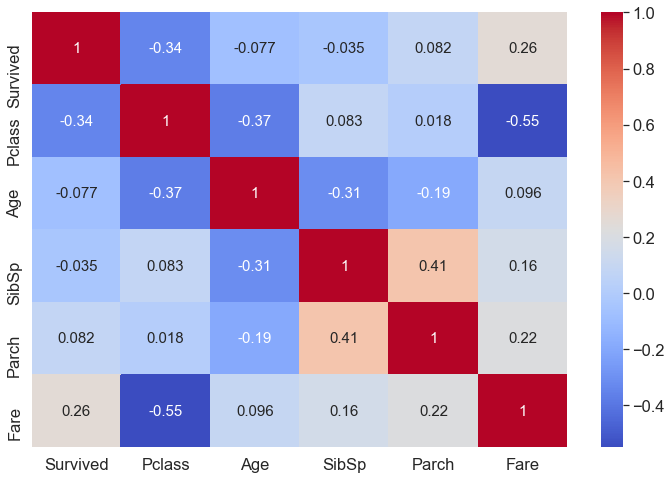

In [7]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.5)
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={'size':15})
plt.show()

Pclass correlates best with the age feature, so we should use the pclass to impute the missing age values!! now lets check if there are any relationship of age with respect to pclass and sex combined

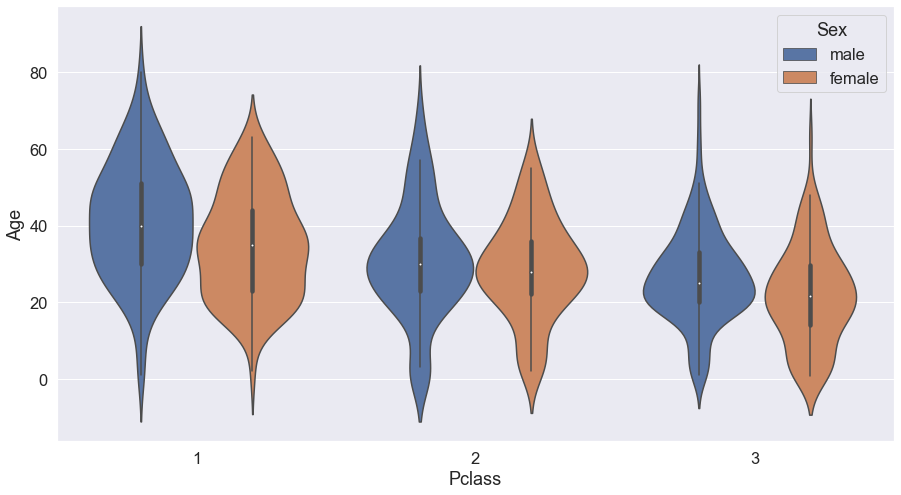

In [8]:
plt.figure(figsize=(15, 8))
sns.violinplot(data=train, x='Pclass', hue='Sex', y='Age', inner='box')
plt.show()

We can see that the meidan age(white dot in the middle) for each gender is slightly different and there is a general trend of decrease in median age for both the genders from Pclass 1 to 3.

Now the next features with missing value is the Cabin feature, but the Cabin feature has a lot of missing value for us to arrive at a acceptable conclusion to impute missing values using correlation, and the feature has to many missing values for us to simply impute the missing values with the mean or median for the values of the feature.

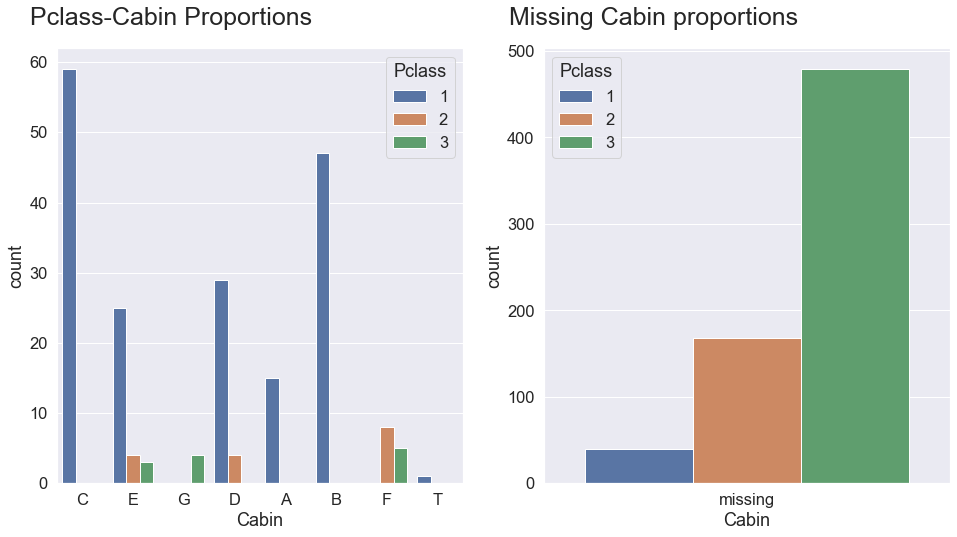

In [9]:
temp = train.copy()
temp['Cabin'] = temp.Cabin.str.extract(pat='([A-Z])')

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.countplot(data=temp, x='Cabin', hue='Pclass', ax=ax[0])
ax[0].set_title('Pclass-Cabin Proportions', x=0.28, y=1.04, size=25)

temp.Cabin.fillna('missing', inplace=True)
temp_missing = temp.loc[temp.Cabin == 'missing']

sns.countplot(data=temp_missing, x='Cabin', hue='Pclass')
ax[1].set_title('Missing Cabin proportions', x=0.27, y=1.04, size=25)

plt.show()

One way to impute values would be to just fill in the Cabins using the proportions as shown above. The missing values for Cabins in Pclass 1 as we see in the right plot, are less than all the other classes and these missing values will be imputed into the Cabins A,B,C,D,E only as they are the only Cabins where the Pclass 1 passengers are present, depending upon the already available Pclass 1 passenger propotions in these Cabins as shown left plot, But imputing values like this will create noise in already available information!! We might get a great result if the missing values got imputed correctly, But that will depend upon luck. So we should just impute the missing value as 'missing', atleast we retain the already available information free of noise.

We should also just simplify this feature and Combine Cabin A, B, C as deck ABC and D, E as DE and F, G as FG.

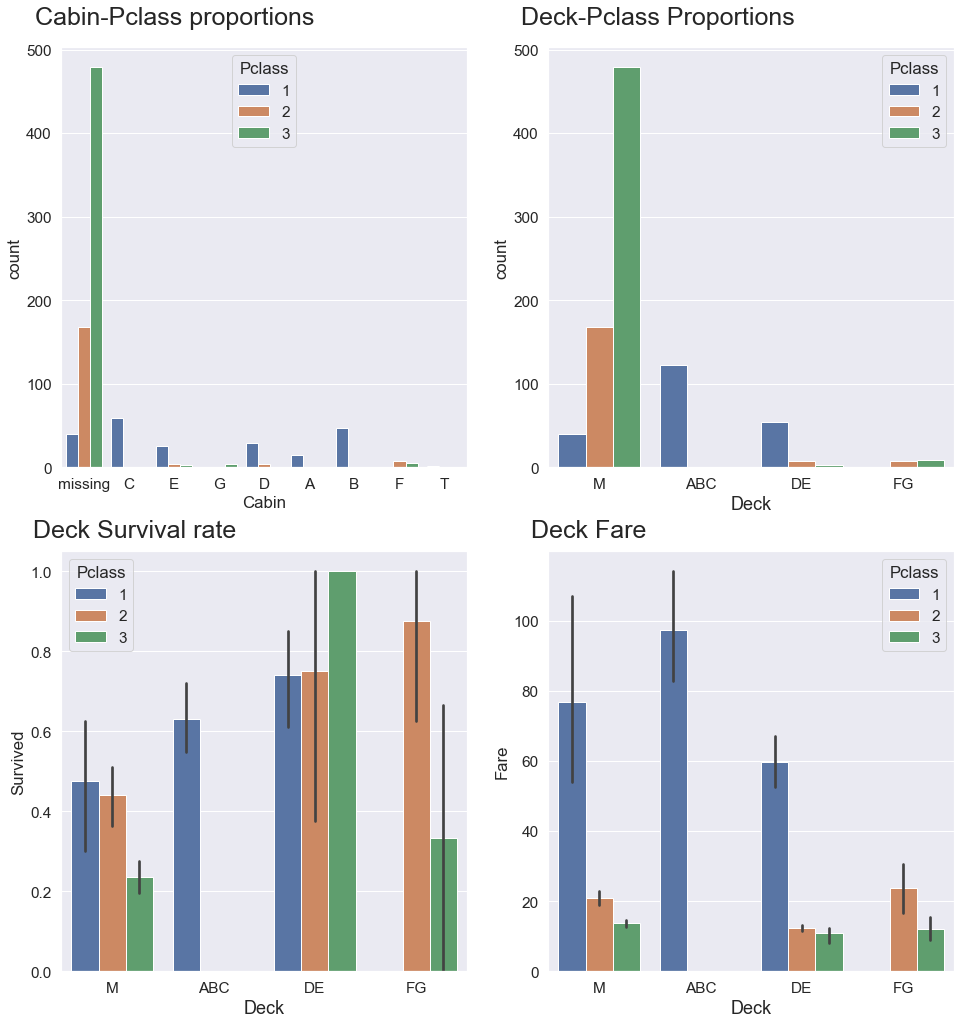

In [10]:
temp = train.copy()
temp['Cabin'] = temp.Cabin.str.extract(pat='([A-Z])')
temp.Cabin.fillna('missing', inplace=True)

sns.set(font_scale=1.4)
fig, ax = plt.subplots(2, 2, figsize=(16, 17))
sns.countplot(data=temp, x='Cabin', hue='Pclass', ax=ax[0, 0])
ax[0, 0].set_title('Cabin-Pclass proportions', x=0.28, y=1.04, size=25)



temp.Cabin.replace({'A':'ABC', 'B':'ABC', 'C':'ABC', 
                    'D':'DE', 'E':'DE', 'F':'FG', 
                    'G':'FG', 'T':'ABC', 'missing':'M'}, inplace=True)


sns.countplot(data=temp, x='Cabin', hue='Pclass', ax=ax[0, 1])
ax[0, 1].set_title('Deck-Pclass Proportions', x=0.27, y=1.04, size=25)
ax[0, 1].set_xlabel('Deck', size=18)



sns.barplot(data=temp, x='Cabin', y='Survived', hue='Pclass', ax=ax[1, 0])
ax[1, 0].set_title('Deck Survival rate', x=0.18, y=1.02, size=25)
ax[1, 0].set_xlabel('Deck', size=18)


sns.barplot(data=temp, x='Cabin', y='Fare', hue='Pclass', ax=ax[1, 1])
ax[1, 1].set_title('Deck Fare', x=0.1, y=1.02, size=25)
ax[1, 1].set_xlabel('Deck', size=18)

plt.show()

The feature looks more balanced now and we can see that now we can say that deck 'M' is the deck where most of the pclass 2 and 3 are present whereas deck ABC is where most pclass 1 are present. We can see from the plots that deck DE had the highest survival rate!!! and deck 'M' has the lowest survival rate. 

The great thing about this simplification from 'Cabin' to 'Deck' is that we have cornered the Pclass 2 and 3 passengers which had the lowest survival rates in new deck M we created!! in all the other decks it seems that they had better chance of survival!! Compare the **Deck-Pclass Proportions** and the **Deck Survival rate**, you can clearly see that those few Pclass 2 and 3 passenger in deck DE and FG have good survival chance, most of the Pclass 2 and 3 passengers are in the Deck 'M' and their survival rate is not good!!

This feature helps to harness this pattern!!!

Lets impute the missing values as per the above understandings...

In [11]:
def imputer(df):
    
    # imputing missing age values
    
    age_impute_series = df.groupby(['Pclass', 'Sex']).Age.transform('mean')
    df.Age.fillna(age_impute_series, inplace=True)
    
    # imputing Cabin missing value.
    df.Cabin = df.Cabin.str.extract(pat='([A-Z])')
    
    df.Cabin.fillna('M', inplace=True)
    
    df['Deck'] = df.Cabin.replace({'A':'ABC', 'B':'ABC', 'C':'ABC', 'D':'DE', 'E':'DE', 'F':'FG', 
                                   'G':'FG', 'T':'ABC'}) # we will drop the Cabin here and only take Deck from here on with us!!
    
    df.drop('Cabin', axis=1, inplace=True)
    
    # lets just finally fill all the left over missig value with the mode of the feature.
    for feature in df.columns:
        df[feature].fillna(df[feature].mode()[0], inplace=True)
        
    return df

In [12]:
train_imputed = imputer(train.copy())
test_imputed = imputer(test.copy())

## Feature creation through EDA


### Target Distribution

This is an important EDA step, to explore the distribution of values of feature with the Target, this EDA step provides us with good understanding of the features and helps us uncover the possibility of feature simplification, combinination etc.

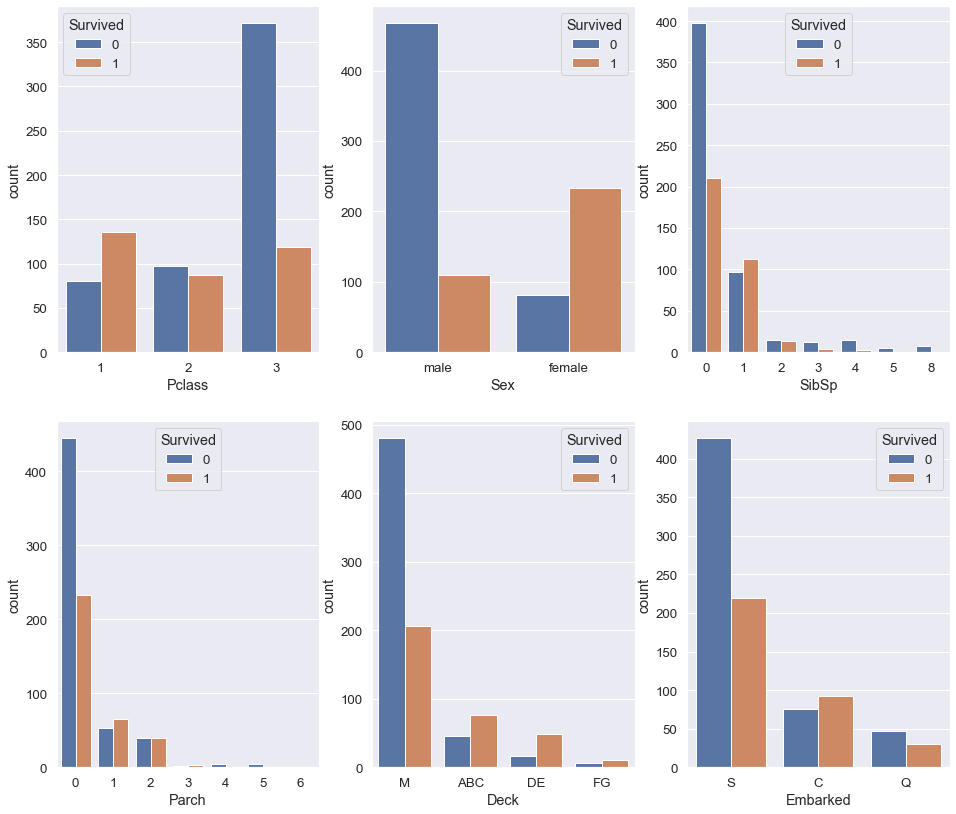

In [13]:
cat_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Deck', 'Embarked']

plt.figure(figsize=(16, 14))
sns.set(font_scale= 1.2)
for i, feature in enumerate(cat_features):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=train_imputed, x=feature, hue='Survived')   

Everything looks great, there are trends which all the categories in categorical feature follow with target. We can observe that it will be beneficial to combine the SibSp and Parch into a common feature named Family_size and further simplification into category such as 'Alone', 'Small_family', 'large_family' can help us capture the trend better, which is that for small family the survival rate is better, a person is more likely to survive if they had 2 to 4 Family size(Parch + SibSp)!!

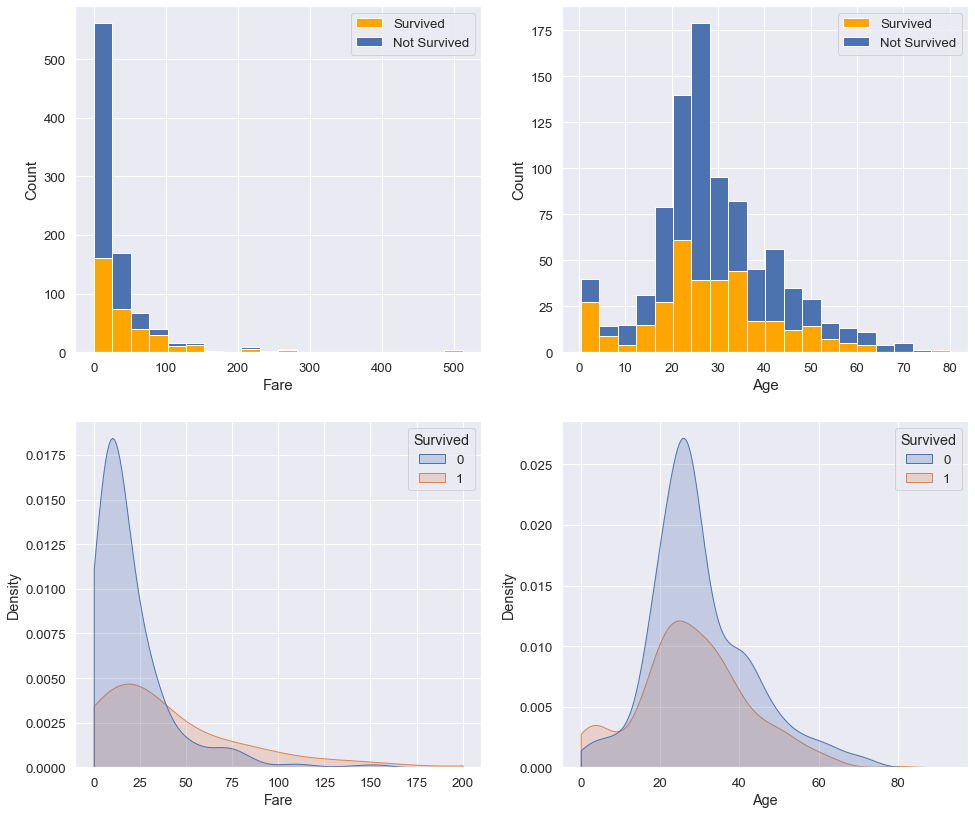

In [454]:
num_features = ['Fare', 'Age']

plt.figure(figsize=(16, 14))
for i, feature in enumerate(num_features):
    plt.subplot(2, 2, i+1)
    plt.hist(x=[train_imputed[feature][train_imputed['Survived'] == 1], train_imputed[feature][train_imputed['Survived']==0]],
            stacked=True, label=['Survived', 'Not Survived'], bins=20, color=['orange', 'b'])
    plt.legend()
    plt.xlabel(f'{feature}', fontsize=15)
    plt.ylabel('Count', fontsize=15)

for i, feature in enumerate(num_features):
    plt.subplot(2, 2, i+3)
    sns.kdeplot(data=train_imputed, x=feature, clip=[0, 200], hue='Survived', fill=True)

From the Fare plot we can see that as the fare increases the ratio of Survived to Not Survived also increases, we might be able to simplify the Fare feature into bins and capture this trend in a better way, it might or might not be helpful to do so, so we will have to cross check this decision by **grid searching this through a pipeline**(*detailed explanation on this technique later*)!! 


### Binning the Fare feature

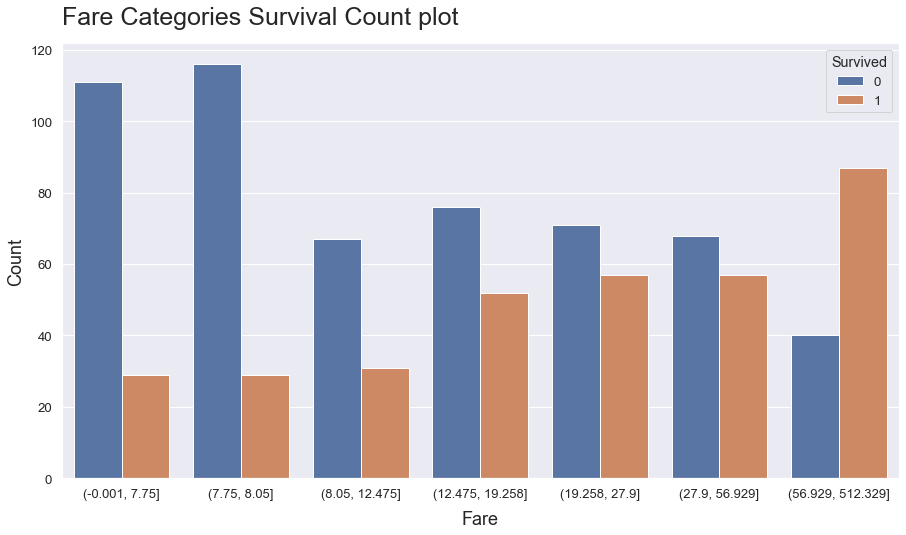

In [455]:
temp = train_imputed.copy()
temp['Fare'] = pd.qcut(temp.Fare, 7)

plt.figure(figsize=(15, 8))
sns.countplot(data=temp, x='Fare', hue='Survived')

plt.ylabel('Count', fontsize=18, labelpad=5)
plt.xlabel('Fare', fontsize=18, labelpad=10)
plt.tick_params(axis='x', labelsize=13)

plt.title('Fare Categories Survival Count plot', y=1.03, fontsize=25, loc='Left')
plt.show()

Yup!! looks great, this is the trend we observed in the plot in last section. Binning helped us express this relation better or we can say that we are able it visualize this feature better as humans, but maybe the continuous form is better as per the algorithm... But atleast we know what we wish to check out by asking this question to our model that what it likes and what it does not(*More on this in Data set creation section*)!! 

If we wish to use the feature as above, we will have to perform Ordinal encoding, where we encode the higher fare category with higher numeric value, for eg:- (-0.001, 7.55] -> 1, (7.55, 7.854] -> 2, (7.854, 8.05] -> 3 and so on. 

**Warning**:-

We can use LabelEncoder from scikit learn api to perform ordinal encoding only because there is order already present in our category which can be correctly understood by the LabelEncoder. But if the order present cannot be understood by the LabelEncoder for eg: Freezing, Cold, Warm, Hot, Lava Hot will be encoded as 2, 1, 5, 3, 4 on the basis of alphabetical order, which is not the correct order for this ordinal feature, it should be 1, 2, 3, 4, 5!! 

**Always beware of this trap!!!**

### Binning age feature

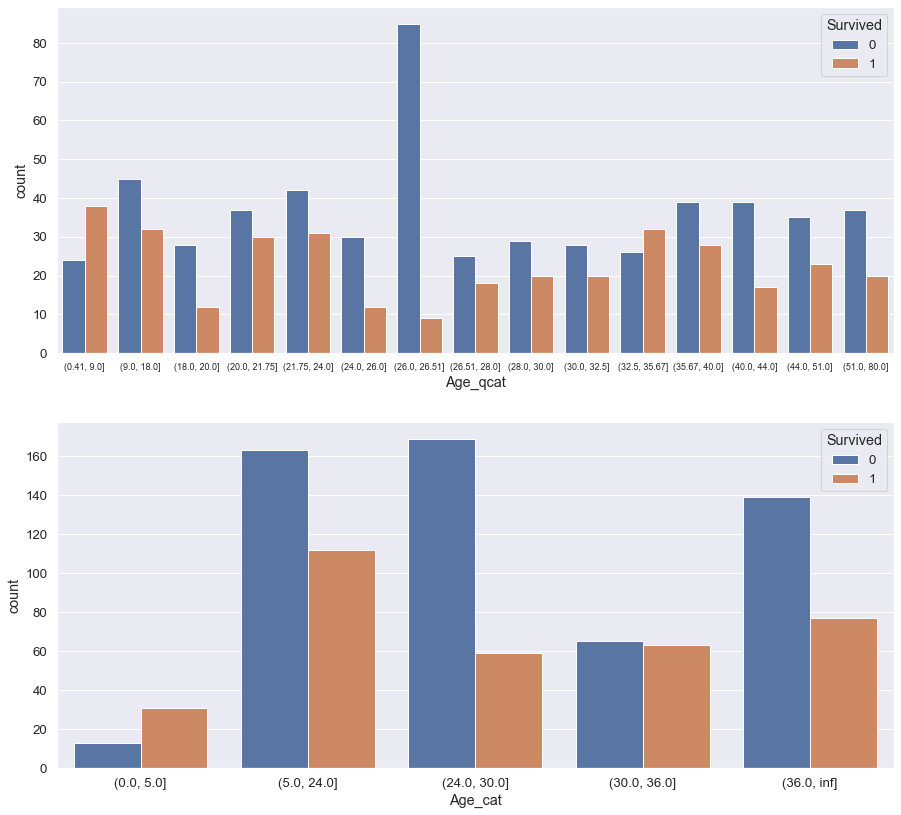

In [14]:
temp = train_imputed.copy()
temp['Age_cat'] = pd.cut(temp.Age, bins=[0, 5, 24, 30, 36, np.inf])
temp['Age_qcat'] = pd.qcut(temp.Age, 15, precision=2)

fig, ax = plt.subplots(2, 1, figsize=(15, 14))

sns.countplot(data=temp, x='Age_qcat', hue='Survived', ax=ax[0])
ax[0].tick_params(axis='x', labelsize=9)

sns.countplot(data=temp, x='Age_cat', hue='Survived', ax=ax[1])

plt.show()

from the second plot we can see that (0.0, 5.0] is a great age bracket for survival, whereas (24.0, 34.0] is the worst, for the (30.0, 36.0] category chances seems to 50-50, i have also plotted a qcut plot with 15 quantiles, just to show that how i visualized the age distributions in the second plot, for the second plot i wanted to have categories with some significant info gain, the above plot shows some good survival rate distribution for the categories we have selected after we went through the first plot.... Just a small trick to bin features to get better info gain for beginners to keep in mind.. 

**After testing out**:

The Age_cat feature improved the results for XGBClassifier and the GradientBoostingCLassifier significantly, observed 1% improvement from continuous age feature to Age_cat!!!

For the titanc dataset many have observed that binning the continuous features helped improve the results slightly, as you can see that binning can let you express the survival chances a little better and in a simpler way, So always test this out with other datasets you work with and test out whether it helps or not!!

### Ticket based features

Ticket feature contains tickets with few of them with alphabets and some of them with only numbers, we could extract this relation but it might not be useful as it may be the case that this relation is related to the Embarked feature and depending upon where you Embarked you might have ticket code in only numbers or with some alphabets... rather we can also extract the frequency of tickets, there are people with same ticket numbers which shows that group of friends and family travelled together and with same ticket number.

first lets check out if just dividing ticket into ticket with alphabets and only numeric serial code helps or not... Then we will perform even finer ticket categorization.

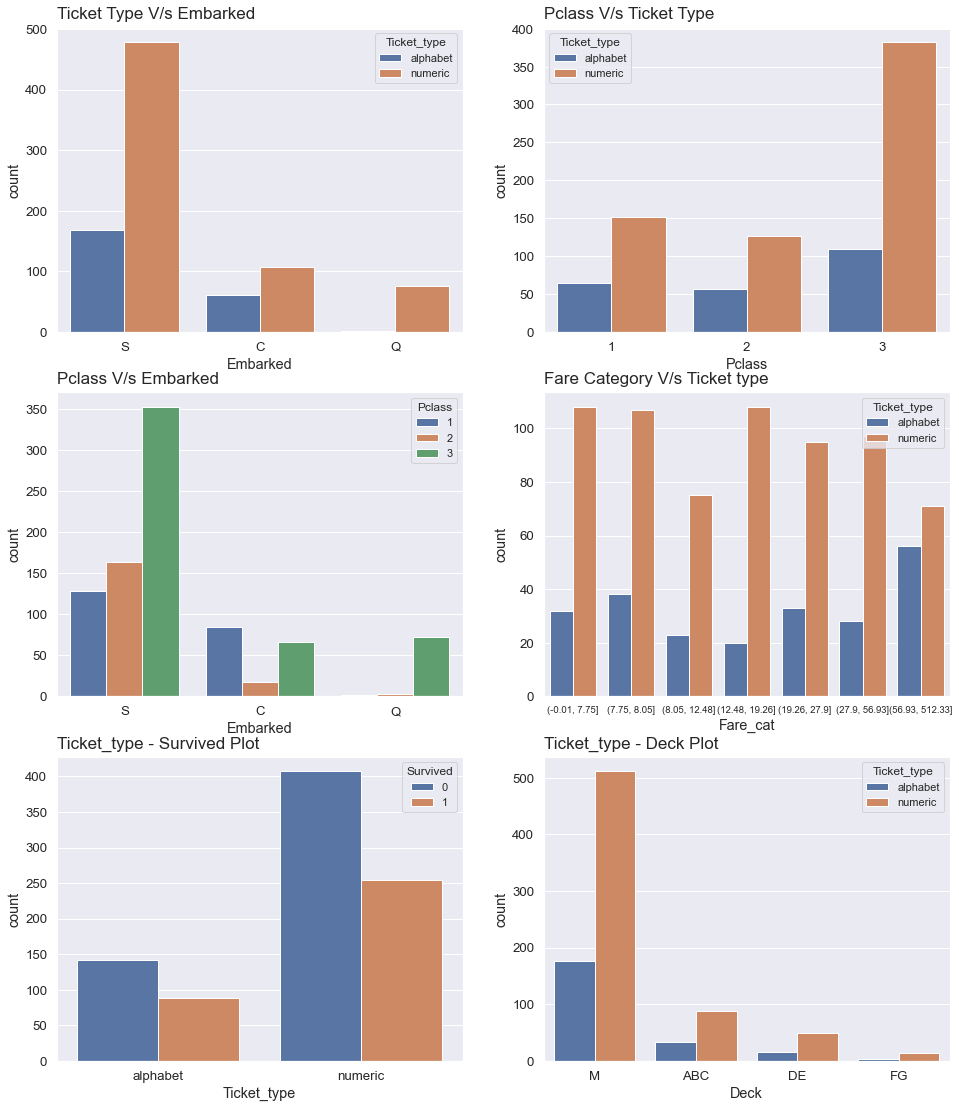

In [15]:
temp = train_imputed.copy()
temp['Ticket_type'] = pd.Series(np.where(temp.Ticket.str.contains(pat='[A-Z]'), 'alphabet', 'numeric'), index=temp.index)
temp['Fare_cat'] = pd.qcut(temp.Fare, 7, precision=2)

y=1.01
size=17
fig, ax = plt.subplots(3, 2, figsize=(16, 19))
sns.set(font_scale=1)

sns.countplot(data=temp, x='Embarked', hue='Ticket_type', ax=ax[0, 0])
ax[0, 0].set_title('Ticket Type V/s Embarked', size=size, loc='Left', y=y)


sns.countplot(data=temp, x='Pclass', hue='Ticket_type', ax=ax[0, 1])
ax[0, 1].set_title('Pclass V/s Ticket Type', size=size, loc='Left', y=y)

sns.countplot(data=temp, x='Embarked', hue='Pclass', ax=ax[1, 0])
ax[1, 0].set_title('Pclass V/s Embarked', size=size, loc='Left', y=y)

sns.countplot(data=temp, x='Fare_cat', hue='Ticket_type', ax=ax[1, 1])
ax[1, 1].set_title('Fare Category V/s Ticket type', size=size, loc='Left', y=y)
ax[1, 1].tick_params(axis='x', labelsize=9.5)

sns.countplot(data=temp, x='Ticket_type', hue='Survived', ax=ax[2, 0])
ax[2, 0].set_title('Ticket_type - Survived Plot', size=size, loc='Left', y=y)

sns.countplot(data=temp, x='Deck', hue='Ticket_type', ax=ax[2, 1])
ax[2, 1].set_title('Ticket_type - Deck Plot', size=size, loc='Left', y=y)

plt.show()

As seen from above, no general trend is visible by categorizing ticket with or without alphabets. There are few points to note though: 
* Mostly numeric tickets were sold at the 'Q' which is Queenstown.
* Proportion of ticket with alphabets bought is less for Pclass 3 as seen from 'Pclass V/s Ticket type plot'.


Ticket type does not show any patterns in the Fare V/s Ticket type plot..... it was kind of disappointing :(

Overall there is no pattern in Ticket type V/s Fare, Deck, Pclass.... This feature does not look that good.


Finally, it may become useful... again.. you already know by now :D...we will have to test it out in Dataset creation section using grid search.


Now lets extract even finer ticket types, maybe model finds some use out of it... we should check it out!!

This pattern has match groups. To actually get the groups, use str.extract.


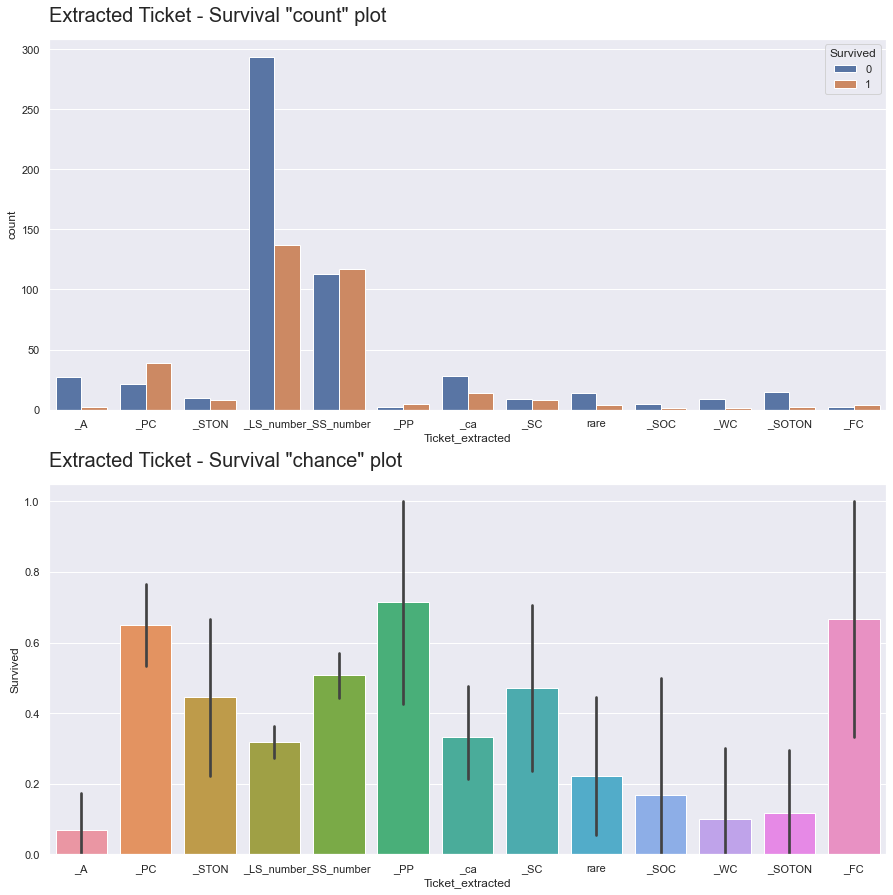

In [16]:
def ticket_extractor(ticket):
    alpha = re.sub('\d', '', ticket)
    if alpha:
        return alpha
    else:
        num = re.search('\d{1,9}', ticket)
        return ticket
    
temp = train_imputed.copy()
temp['Ticket_extracted'] = temp.Ticket.apply(ticket_extractor)
for i in range(len(temp.Ticket)):
    try:
        int(temp.Ticket_extracted.iloc[i])
        temp.Ticket_extracted.iloc[i] = f'Num_{len(temp.Ticket_extracted.iloc[i])}'
    except:
        continue
        
for label, pattern in [('_ca', 'C[.]?A[.]?'), ('_PC', 'PC'), ('_SOTON', 'SOTON'), ('_STON', 'STON'), 
                       ('_WC', 'W[.]?[/]?C'), ('_SC', 'S[.]?C[.]?'), ('_A', 'A[.]?'), ('_SOC', 'S[.]?O[.]?[/]?C'), 
                       ('_PP', 'PP'), ('_FC', '(F.C.|F.C.C.)'), ('_LS_number', 'Num_(6|7)'), ('_SS_number', 'Num_(3|4|5)'), 
                       ('rare', '^[^_]')]:
    temp.Ticket_extracted[temp.Ticket_extracted.str.contains(pattern)] = label
    
temp['Ticket_extracted'].value_counts(dropna=False)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))
sns.countplot(data=temp, x='Ticket_extracted', hue='Survived', ax=ax[0])
ax[0].set_title('Extracted Ticket - Survival "count" plot', size=20, loc='Left', y=1.03)

sns.barplot(data=temp, x='Ticket_extracted', y='Survived', ax=ax[1])
ax[1].set_title('Extracted Ticket - Survival "chance" plot', size=20, loc='Left', y=1.03)

plt.show()

Looks decent, what attracts my attention is the ticket A, PC, CA, Large_Serial_number and Small_Serial_number as they are quite a few of these tickets to be confident in the survival chances shown by these tickets. This feature might help us improve the probability of survival of few passengers and may push there probability of survival over 50% if they actually survived, to get classified as survived, which is actually the problem with many instances as they get classified as not survived, i.e probability of survival is lower than 50%.

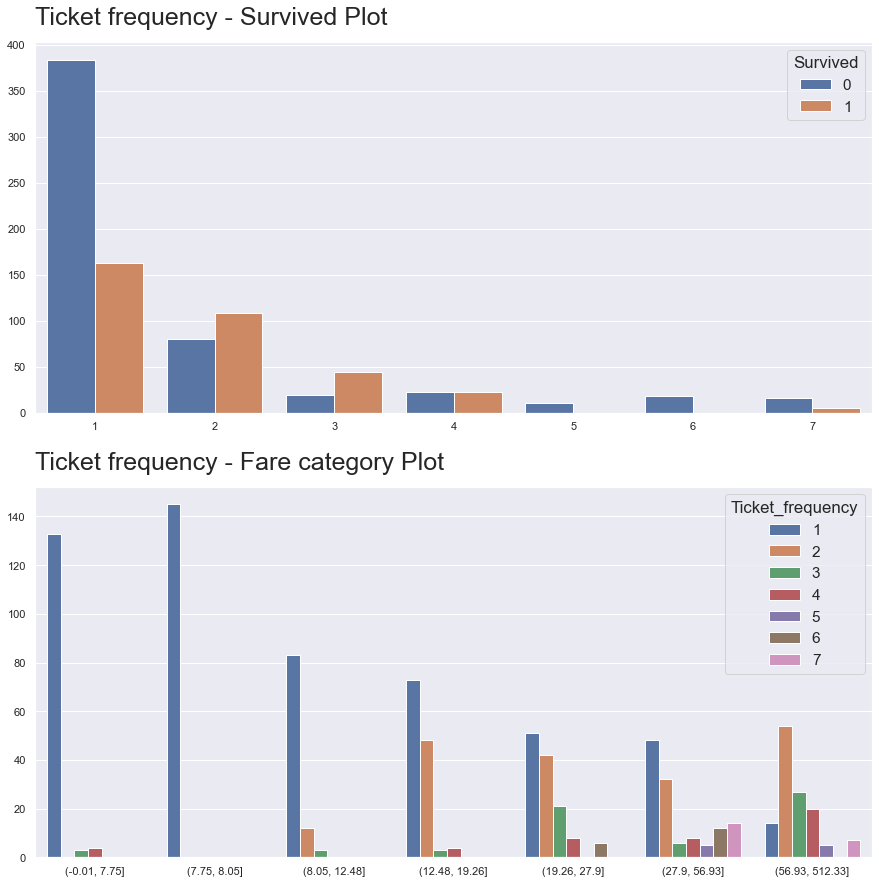

In [17]:
temp['Ticket_frequency'] =temp.Ticket.map(temp.Ticket.value_counts(dropna=False))
temp['Fare_cat'] = pd.qcut(temp.Fare, 7, precision=2)

y=1.03
size=25
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
sns.set(font_scale=1.4)

sns.countplot(data=temp, x='Ticket_frequency', hue='Survived', ax=ax[0])
ax[0].set_title('Ticket frequency - Survived Plot', loc='Left', y=y, size=size)
ax[0].set_xlabel('')
ax[0].set_ylabel('')

sns.countplot(data=temp, x='Fare_cat', hue='Ticket_frequency', ax=ax[1])
ax[1].set_title('Ticket frequency - Fare category Plot', loc='Left', y=y, size=size)
ax[1].set_xlabel('')
ax[1].set_ylabel('')

plt.show()

**Findings:**
* We can clearly see from the above plot that the survival chance for people with ticket frequency from 2-4 was more.
* We were also able to uncover new information, it seems that higher frequency mean higher ticket fare which is actually the cummulative ticket price for all passenger, which means that Fare column does not contain the fare for an individual person but the total fare for a group with same ticket!! 
* we might be able to derive a new feature which is fare_per_individual, lets check it out if it is good or not!!

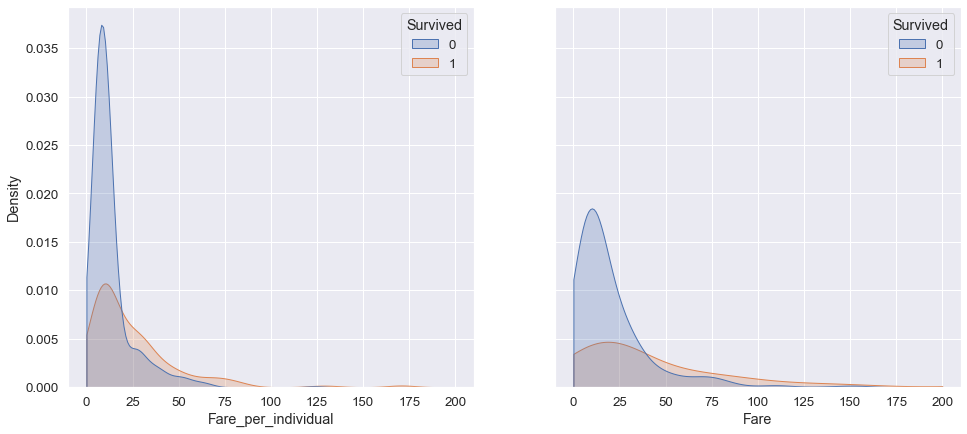

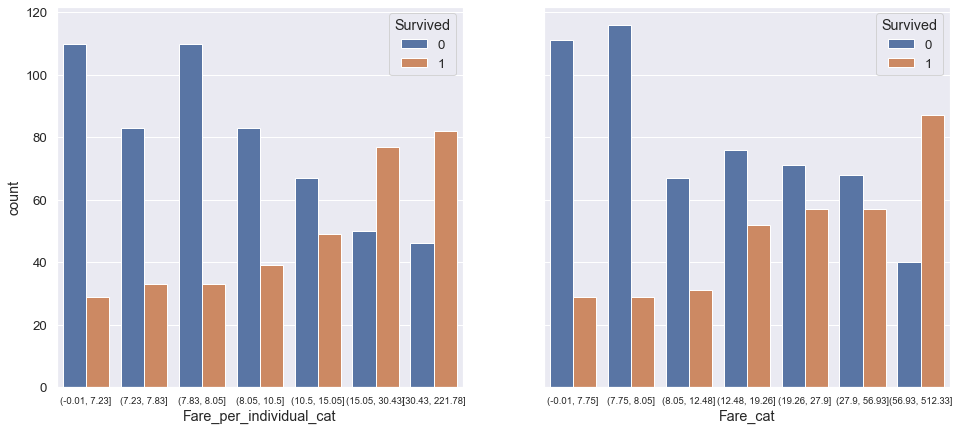

In [18]:
temp = train_imputed.copy()
temp['Ticket_frequency'] =temp.Ticket.map(temp.Ticket.value_counts(dropna=False))
temp['Fare_cat'] = pd.qcut(temp.Fare, 7, precision=2)
temp['Fare_per_individual'] = temp['Fare'] / temp['Ticket_frequency']
temp['Fare_per_individual_cat'] = pd.qcut(temp.Fare_per_individual, 7, precision=2)

y = 1.03
size = 18
sns.set(font_scale=1.2)
fig, ax = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

sns.kdeplot(data=temp, x='Fare_per_individual', hue='Survived', clip=[0, 200], fill=True, ax=ax[0])

sns.kdeplot(data=temp, x='Fare', hue='Survived', clip=[0, 200],  fill=True, ax=ax[1])
ax[1].set_ylabel('')

fig, ax = plt.subplots(1, 2, figsize=(16, 7), sharey=True)

sns.countplot(data=temp, x='Fare_per_individual_cat', hue='Survived', ax=ax[0])
ax[0].tick_params(axis='x', labelsize=9.5)
#ax[0].set_ylabel('')
#ax[0].set_xlabel('')

sns.countplot(data=temp, x='Fare_cat', hue='Survived', ax=ax[1])
ax[1].tick_params(axis='x', labelsize=9.5)
ax[1].set_ylabel('')
#ax[1].set_xlabel('')

plt.show()

**Findings :**
* From the above plot we can see that the probability distribution function did not show much difference, for the fare_per_individual it just got squeezed to the left and the corresponding values in the y axis were scaled equally...
* But when we tried out making fare_per_individual category, we can see that fare_per_individual category gave us a better steady increase in survival rate from left to righ!!! 

Until now we have Pointed out a lot of possibilities for feature engineering and there so many tough decisions to make as per what to keep and what to drop, we only want the best, informative features to achieve best results, But there is no shortcut to this, we cannot just simply know what works best with the given data and our models.... We will have to test it all out!! Though the Feature Engineering class will help us to quickly narrow down our search for the best data sets by quickly dropping out dataset made by selecting features which are not good. 

### Family Size Feature

In the data provided to us, each individual has a SibSp and Parch, so if we add these features together for an individual and add 1 to it, 1 being the individual themself, we can create a new feature Family_size.

It is an important feature as it reveals that passengers with family size 2 - 4 had a better survival rate than passengers travelling alone or who had larger families.

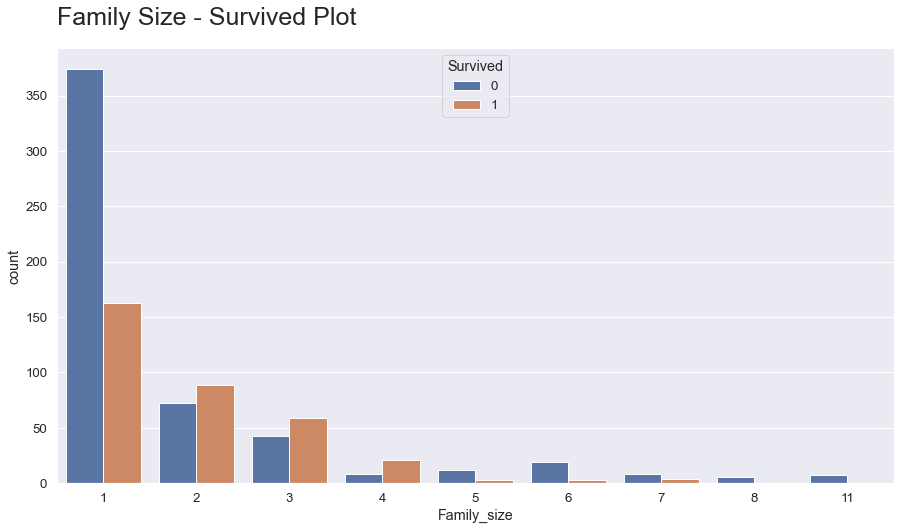

In [19]:
temp = train_imputed.copy()
temp['Family_size'] = temp['SibSp'] + temp['Parch'] + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.countplot(data=temp, x='Family_size', hue='Survived', ax=ax)
ax.set_title('Family Size - Survived Plot', size=25, loc='Left', y=1.04)

plt.show()

Looks great!! the survival pattern is quite clear... but can we simplify and combine the family size 2-4 as 'small family' and family size of 1 as 'alone' to simplify the feature?

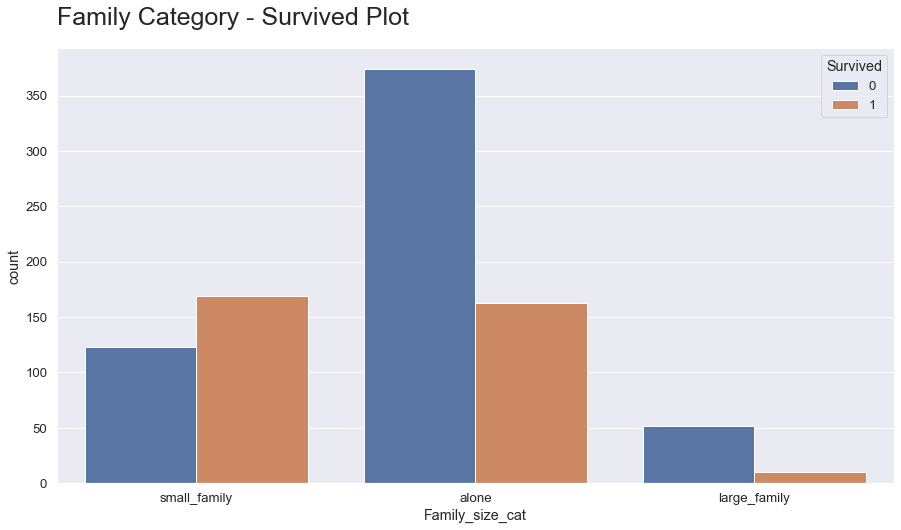

In [20]:
temp['Family_size_cat'] = temp['Family_size'].replace({1:'alone', 2:'small_family', 3:'small_family', 4:'small_family'
                                                      ,5:'large_family', 6:'large_family', 7:'large_family'
                                                      ,8:'large_family', 9:'large_family', 10:'large_family', 
                                                       11:'large_family'})

fig, ax = plt.subplots(1, 1, figsize=(15, 8))

sns.countplot(data=temp, x='Family_size_cat', hue='Survived', ax=ax)
ax.set_title('Family Category - Survived Plot', size=25, loc='Left', y=1.04)

plt.show()

Yup, things look simpler and neat!! But again, it looks good to us but model might not find it as helpful as we think, maybe it could have found patterns with those family size numbers and some other feature, which it would not be able to harness as easily now, you never know... what we can be sure about is that we have made the feature simpler, if we one hot encode it we will have fewer dimensions, which is a good thing. Lets say we had many features which had to be one hot encoded but there cardinality(number of different categories in categorical feature) was high, label encoding was not an option and if we one hot encoded the feature we would be struck by curse of dimensionality, in such case if all the categorical features could be simplified in such a easy, beautiful way, nothing like that!!

But we do not have that problem at present, we have a small dataset and not aot of features with high cardinality, so we will have to figure out whether this feature helps or not. 

### Name Length Feature

One of the features that can be derived from the Name feature is the Name length, the idea behind this is that people with higher status usually had longer names, we can use this fact to create a feature with name lengths.
I got to know about this relation in this excellent notebook -> https://www.kaggle.com/sreevishnudamodaran/ultimate-eda-fe-neural-network-model-top-2

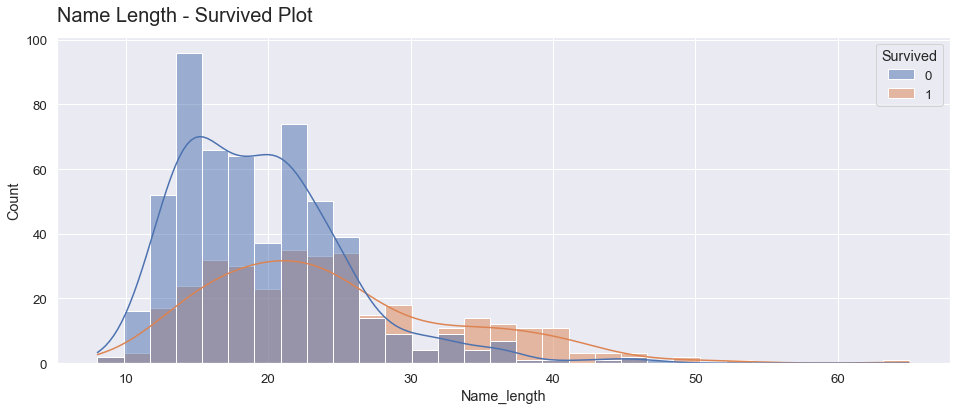

In [21]:
temp = train_imputed.copy()
temp['Name_length'] = temp.Name.str.replace(pat='[^a-zA-Z]', repl='').str.len()

fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.histplot(data=temp, x='Name_length', hue='Survived', kde=True, fill=True, ax=ax)
ax.set_title('Name Length - Survived Plot', size=20, loc='Left', y=1.03)

plt.show()

Great!! we can see that with increase in the name length the survival rate increases!

### Name Title

In [22]:
temp = train_imputed.copy()

temp['Title'] = temp.Name.str.extract(pat='([a-zA-Z]+\.)')

temp.Title[~temp.Title.isin(['Mr.', 'Miss.', 'Mrs.', 'Master.'])] = 'rare'

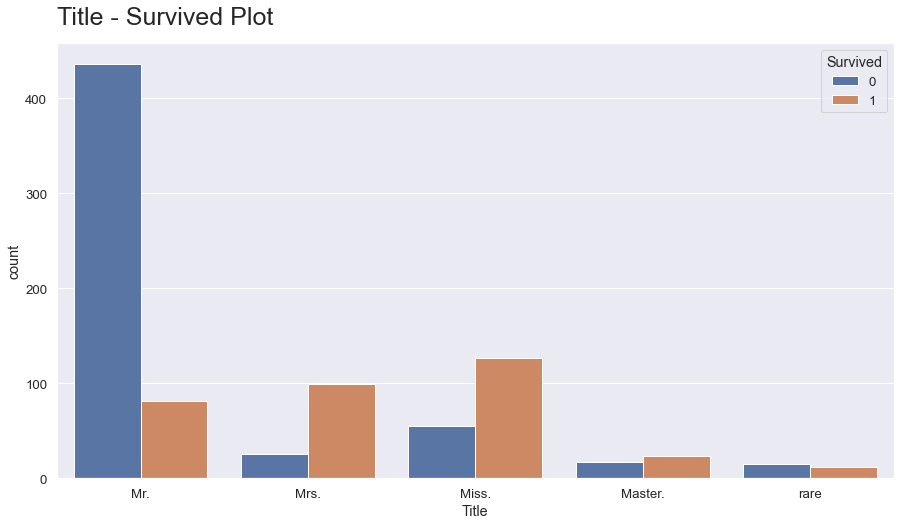

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.countplot(data=temp, x='Title', hue='Survived', ax=ax)
ax.set_title('Title - Survived Plot', loc='Left', size=25, y=1.03)
plt.show()

The above plot shows that Mrs., Miss. and Master. titles had better chances if survival, chances of survival is less than that for survival in case of Mr. and rare title, but it is worse for the Mr. title.

### Survival Rate

***This is the most important feature that almost all the top leaderboard submissions will have.***


Intuition behind the Survival rate feature:

It was observed that usually people belonging to a family and Ticket group survived together or died together, this can help us assign survival rate for instances in test set which belonged to a family or ticket group in training set, this can help us make it easier for the model predict few more instances and boost the score... All this made more clear by the visualiations below!!


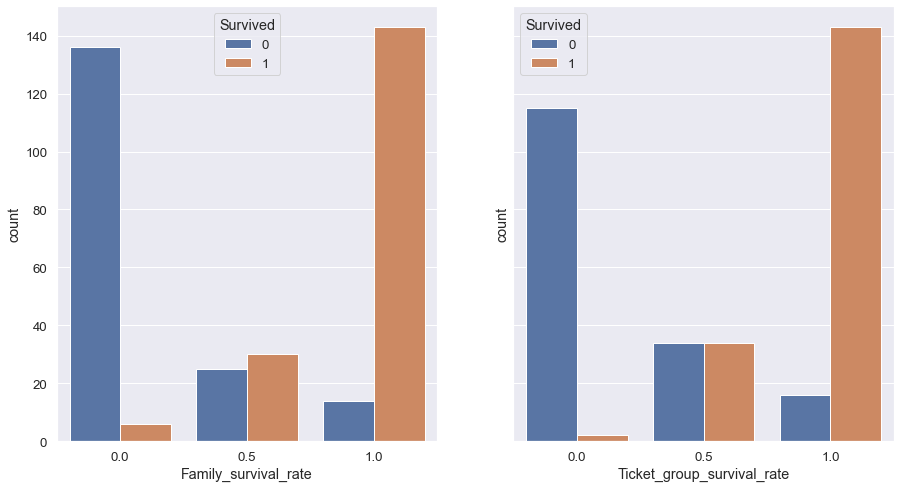

In [24]:
temp = train_imputed.copy()
temp['Family_name'] = temp.Name.str.split(',', n=1, expand=True).iloc[:, 0]
temp['Family_size'] = temp['SibSp'] + temp['Parch'] + 1
temp['Ticket_frequency'] = temp.Ticket.map(temp.Ticket.value_counts()) 

temp['Family_survival_rate'] = temp.Family_name.map(temp.groupby(['Family_name']).Survived.median())
temp['Ticket_group_survival_rate'] = temp.Ticket.map(temp.groupby(['Ticket']).Survived.median())


fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

sns.countplot(data=temp[temp['Family_size'] > 1], x='Family_survival_rate', hue='Survived', ax=ax[0])
# we will only take into account those instance with Family size > 1 for visualization to explore the effectiveness of the 
# Survival rate feature

sns.countplot(data=temp[temp['Ticket_frequency'] > 1], x='Ticket_group_survival_rate', hue='Survived', ax=ax[1])
# we will only take into account those instance with Ticket_frequency > 1 for visualization to explore the effectiveness of the 
# Survival rate feature

plt.show()

Well, things are crystal clear now!! those passengers which were assigned survival rate 0 because the median survival of the group was 0 actually only very few of them survived!! same the case when we see the passengers with median family survival rate 1, majority survived!!

***Now how does this feature help us get better results??***

First we have to understand that getting an accuracy score of 80% and getting to top 4% of the leaderboard is possible just by tunning model hyper parameters well and performing good feature encoding practices, but moving up from there is very difficult unless you have feature engineered very good features such as the one we are creating right now... The difference of 80% to 84% accuracy is just of about 2-4 more correct survival predictions. i got up to 79 % with just stacking and good encoding practice, check it out ->https://www.kaggle.com/awwalmalhi/comprehensive-beginners-guide-to-top-6

Lets say we have few family members or ticket group members which were not in training set but in test set, we can easily, with confidence assign a survival rate to them in the test set depending upon the above results and turns out that ususally people are able to push from 75% to 81-83% with this feature!! just by predicting few more stubborn instances as 1!!

**Note**:

The way we created the survival rate feature has been copied from the following notebook -->https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83, i tried creating my own, but it did not work!! :P.... to be honset in my personal opinion features created by leaking target into the dataset is not a good practice and there is not much learning one could gain by observing such practices... such techniques do not exist in real work data science, Datasets are huge and there will be lot of out of sample data from multiple sources, you can't rely on leaking target into the dataset and overfitting your model on the training set, so your model will perform horribly with such leaked features on out of sample data... One could argue that the way we created this feature is somewhat similar to target encoding, where we use target to encode the categorical feature.. But that is why target encoded features are notorious for making the model overfit the data and require many techniques to appease this problem such as adding smoothing etc. **I am yet to find results as good as 83-85% and without using survival rate type feature** if someone can reach it, thats remarkable!!!

why does this work in case titanic dataset?

well simple reason is, as we discussed above, there are features which have deeper logical relation with target which humans can find out but not machines and the dataset is small, with same kind of noise in training and test and bound to stay of same size for eternity... So you can get away with using such feature and boosting accuracy...

### EDA conclusion

***Missing value imputation***
* imputing Age feature
* imputing Embarked feature

We were able to find better ways to impute the Age and Embarked feature with reasonable support from the present data explored via Visualizations, you should too explore the data through EDA and find out best ways to impute data rather straight away using sklearn.impute or .fillna()


***Feature creation through EDA***

we were able to explore feature simplification, combination possibilities and possibilities to derive new features with proper support for these decisions from the present data...
 * Bin Fare feature to simplify and express patterns
 * Bin Age feature to simplify and express patterns
 * Better way to extract information from Ticket feature and creation of Ticket_frequency feature and Ticket_extracted feature
 * through the Ticket frequency feature we were able to gain information regarding Fare_per_individual feature and possibility of binning it.
 * Family size feature and possibility of simplification
 * Name length feature
 * Survival rate feature
 
 
until now we have created few features and explored possibilities for simplification, we have many possible ways to create the final dataset. There are a lot of decision we will have to make now, some of them are as follows:
* Is binned Fare feature better or the continuous one?
* is Binned Age feature better of the continuous one?
* Should we keep the SibSp and Parch rather than the Combined Family size feature?
* If we should keep the Family_size feature, should we simplify it?
* if we simplify the Family_size feature, should we one hot encode it or Target encode it?
* What features should we drop?
* Should we use StandardScaler, MinMaxScaler or RobustScaler?


These are some of good questions that come to my mind... There can be many more, but lets keep things simple or the class will become difficult to debug XD

# Feature Engineering

In [25]:
def feature_creator(df_train, df_test):
    
    # creating binned fare feature
    df_train['Fare_cat'] = pd.qcut(df_train['Fare'], 7)
    df_test['Fare_cat'] = pd.qcut(df_test['Fare'], 7)
    
    df_train['Fare_cat'] = LabelEncoder().fit_transform(df_train['Fare_cat'])
    df_test['Fare_cat'] = LabelEncoder().fit_transform(df_test['Fare_cat'])
    
    
    
    # creating binned age feature
    df_train['Age_cat'] = pd.cut(df_train.Age, bins=[0, 5, 24, 30, 36, np.inf])
    df_test['Age_cat'] = pd.cut(df_test.Age, bins=[0, 5, 24, 30, 36, np.inf])
    
    df_train['Age_cat'] = LabelEncoder().fit_transform(df_train['Age_cat'])
    df_test['Age_cat'] = LabelEncoder().fit_transform(df_test['Age_cat'])
    
    
    
    # Title feature
    for df in [df_train, df_test]:
        df['Title'] = df.Name.str.extract(pat='([a-zA-Z]+\.)')
        df.Title[~df.Title.isin(['Mr.', 'Miss.', 'Mrs.', 'Master.'])] = 'rare'
        
        

    # creating Ticket frequency feature
    df_full = pd.concat([df_train, df_test], axis=0)
    df_full['Ticket_frequency'] = df_full.Ticket.map(df_full.Ticket.value_counts())
    df_train = df_full.loc[df_train.index]
    df_test = df_full.loc[df_test.index].loc[df_test.index].drop('Survived', axis=1)
    
    
    
    # creating extracted ticket feature
    for df in [df_train, df_test]:
        
        df['Ticket_extracted'] = df.Ticket.apply(ticket_extractor)
        for i in range(len(df.Ticket)):
            try:
                int(df.Ticket_extracted.iloc[i])
                df.Ticket_extracted.iloc[i] = f'Num_{len(df.Ticket_extracted.iloc[i])}'
            except:
                continue

        for label, pattern in [('_ca', 'C[.]?A[.]?'), ('_PC', 'PC'), ('_SOTON', 'SOTON'), ('_STON', 'STON'), 
                               ('_WC', 'W[.]?[/]?C'), ('_SC', 'S[.]?C[.]?'), ('_A', 'A[.]?'), ('_SOC', 'S[.]?O[.]?[/]?C'), 
                               ('_PP', 'PP'), ('_FC', '(F.C.|F.C.C.)'), ('_LS_number', 'Num_(6|7)'), 
                               ('_SS_number', 'Num_(3|4|5)'), ('rare', '^[^_]')]:
            df.Ticket_extracted[df.Ticket_extracted.str.contains(pattern)] = label
            
            
    
    # Fare per individual feature
    #df_train['Fare_per_individual'] = df_train['Fare'] / df_train['Ticket_frequency']
    #df_test['Fare_per_individual'] = df_test['Fare'] / df_test['Ticket_frequency']
    
    #df_train['Fare_per_individual_cat'] = pd.qcut(df_train['Fare_per_individual'], 7)
    #df_test['Fare_per_individual_cat'] = pd.qcut(df_test['Fare_per_individual'], 7)
    
    #df_train['Fare_per_individual_cat'] = LabelEncoder().fit_transform(df_train['Fare_per_individual_cat'])
    #df_test['Fare_per_individual_cat'] = LabelEncoder().fit_transform(df_test['Fare_per_individual_cat'])
    
    
    
    # Family size feature
    df_train['Family_size'] = df_train['SibSp'] + df_train['Parch'] + 1
    df_test['Family_size'] = df_test['SibSp'] + df_test['Parch'] + 1
    
    
    
    # creating binned family sized feature
    df_train['Family_size_cat'] = df_train.Family_size.replace({1:'alone', 2:'small_family', 3:'small_family', 4:'small_family'
                                                               ,5:'large_family', 6:'large_family', 7:'large_family'
                                                               ,8:'large_family', 9:'large_family', 10:'large_family'
                                                               ,11:'large_family'})
    
    df_test['Family_size_cat'] = df_test.Family_size.replace({1:'alone', 2:'small_family', 3:'small_family', 4:'small_family'
                                                               ,5:'large_family', 6:'large_family', 7:'large_family'
                                                               ,8:'large_family', 9:'large_family', 10:'large_family' 
                                                               ,11:'large_family'})
    
    
    
    # Name length feature
    df_train['Name_length'] = df_train.Name.str.replace(pat='[^a-zA-Z]', repl='').str.len()
    df_test['Name_length'] = df_test.Name.str.replace(pat='[^a-zA-Z]', repl='').str.len()
    
    
    
    # survival rate feature
    df_full = pd.concat([df_train, df_test], axis=0).reset_index()

    df_full['Family_name'] = df_full.Name.str.split(',', n=1, expand=True).iloc[:, 0]
    
    df_full['Family_Survival'] = 0.5
    

    for grp, grp_df in df_full.groupby(['Family_name', 'Fare']):
        if (len(grp_df) != 1):
            # Fare and Family_name are used as category to group families together, as these features should be same for
            # families and once we get the groups we filter for grp_df which have ore than 1 length, hence a family.
            for ind, row in grp_df.iterrows():
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    df_full.loc[df_full['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    df_full.loc[df_full['PassengerId'] == passID, 'Family_Survival'] = 0

    for _, grp_df in df_full.groupby('Ticket'):
        if (len(grp_df) != 1):
            for ind, row in grp_df.iterrows():
                if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                    smax = grp_df.drop(ind)['Survived'].max()
                    smin = grp_df.drop(ind)['Survived'].min()
                    passID = row['PassengerId']
                    if (smax == 1.0):
                        df_full.loc[df_full['PassengerId'] == passID, 'Family_Survival'] = 1
                    elif (smin==0.0):
                        df_full.loc[df_full['PassengerId'] == passID, 'Family_Survival'] = 0
     
    df_full.set_index('PassengerId', inplace=True)
    df_train = df_full[:891]
    df_test = df_full[891:]
    
    
    # finally we will drop the family name feature we created to help us create the Survival rate feature.
    df_train.drop(['Family_name'], axis=1, inplace=True)
    df_test.drop(['Family_name', 'Survived'], axis=1, inplace=True)
    
    # lets finally drop the survived from our training set and create the target variable
    y_train =df_train.Survived
    df_train.drop('Survived', axis=1, inplace=True)
    
    return df_train, y_train, df_test

In [26]:
X_train, y_train, X_test = feature_creator(train_imputed.copy(), test_imputed.copy())
y_train = y_train.astype(int)

This pattern has match groups. To actually get the groups, use str.extract.


In [27]:
X_train.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Fare_cat,Age_cat,Title,Ticket_frequency,Ticket_extracted,Family_size,Family_size_cat,Name_length,Family_Survival
PassengerId,,,,,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,M,0,1,Mr.,1,_A,2,small_family,18,0.5
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,ABC,6,4,Mrs.,2,_PC,2,small_family,41,0.5
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,M,1,2,Miss.,1,_STON,1,alone,18,0.5
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,ABC,5,3,Mrs.,2,_LS_number,2,small_family,34,0.0
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,M,1,3,Mr.,1,_LS_number,1,alone,19,0.5


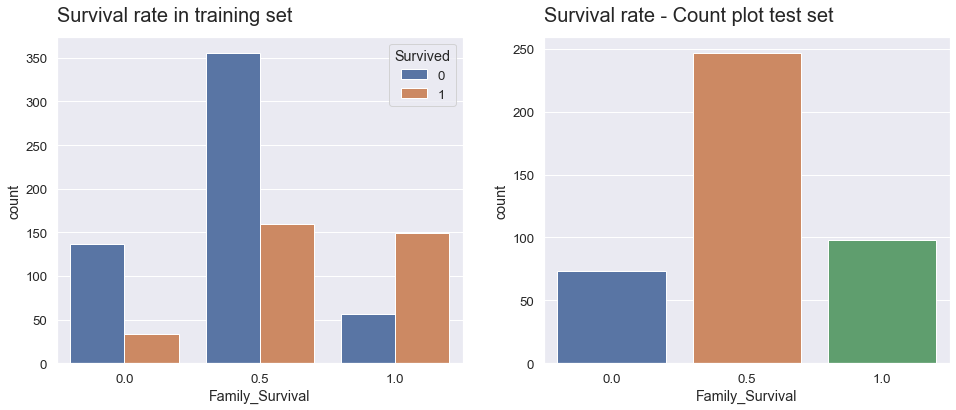

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


size = 20
y = 1.03
X_train['Family_Survival'] = np.round(X_train.Family_Survival, 2)

sns.countplot(data=pd.concat([X_train, y_train], axis=1), x='Family_Survival', hue='Survived', ax=ax[0])
ax[0].set_title('Survival rate in training set', loc='Left', size=size, y=y)


X_test.Family_Survival = np.round(X_test.Family_Survival, 2)
sns.countplot(data=X_test, x='Family_Survival', ax=ax[1])
ax[1].set_title('Survival rate - Count plot test set', loc='Left', size=size, y=y)

plt.show()

What is of importance to us is the left plot where with certain confidence we have assigned the survival rates to the instances and we have about 175 instances for which we have some certainity of final outcome.

### Dataset creation

**Now we are ready to ask questions!!!** Lets create FeatureEngineering class and use it in a pipeline with Logistic Regression(we can use other estimators too, but i prefer to use a simple one to keep computational expense low and search fast), we will pass the questions we wish to ask as the parameter to this class in the pipeline and grid search the whole feature space to narrow down our search for the best dataset!!

* Is binned Fare feature better or the continuous one?
* is Binned Age feature better of the continuous one?
* Should we keep the SibSp and Parch rather than the Combined Family size feature?
* If we should keep the Family_size feature, should we simplify it?
* if we simplify the Family_size feature, should we one hot encode it or Target encode it?
* What features should we drop?
* Should we use StandardScaler, MinMaxScaler or RobustScaler?

Before we get to the above Q/A setion, lets make few transformations i have noted below.
* Pclass and Sex to one hot encodings
* Drop Name and Ticket

In [29]:
# if we wish to create a transformer which we can grid search in a pipeline, that transformer has to inherit from the 
# BaseEstimator class, we will also make our FeatureEngineering transformer inherit from the TransformerMixin which just 
# provides the functionality of fit_transform() method to our transformer.

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self, bin_fare=False, bin_age=True, family_size=True, bin_family_size=True,
                 drop_Name_length=False, drop_Ticket_frequency=False, drop_all=True, drop_Family_Survival=True, 
                 drop_Ticket_extracted=False, scaling='StandardScaler', target_encode_title=True, test=False):
        self.bin_fare = bin_fare
        self.bin_age = bin_age
        #self.bin_fare_individual_cat = bin_fare_individual_cat
        self.family_size = family_size
        self.bin_family_size = bin_family_size
        self.drop_Name_length = drop_Name_length
        self.drop_Ticket_frequency = drop_Ticket_frequency
        self.drop_all = drop_all
        self.drop_Ticket_extracted = drop_Ticket_extracted
        self.scaling = scaling
        self.drop_Family_Survival = drop_Family_Survival
        self.target_encode_title = target_encode_title
        self.transformer = None
        self.drop_list = []
        self.test = test
        
    def fit(self, X, y=None):
        return self # the fit method usually return self only, if not sure, try fitting a scikit learn estimator/transformer.. 
                    # only the fitted object will be returned, fit() will include code in case of these transformers and
                    # estimators but we do not need to have some fitted variables on our dataset before we go for transform,
                    # or atleast the way i am doing it i don't need to. :) 
    
    def transform(self, X, y=None):
        
        X['Pclass'] = X['Pclass'].astype(str) # import convert numeric values to str if we wish to use get_dummies on them.
        dummies = pd.get_dummies(X.loc[:, ['Pclass', 'Sex']], drop_first=True)
        X = pd.concat([X, dummies], axis=1)
        X.drop(['Pclass', 'Sex'], axis=1, inplace=True)
        
        # lets also drop Name and Ticket feature as we have extracted what we needed!!
        X.drop(['Name', 'Ticket'], axis=1, inplace=True)
        
        
        
        
        if self.bin_fare:
            # so if we self.bin_fare = True we want the binned fare, so drop the continuous fare feature.
            self.drop_list.append('Fare')
            
        else:
            self.drop_list.append('Fare_cat')
            
        
        if self.bin_age:
            self.drop_list.append('Age')
        
        else:
            self.drop_list.append('Age_cat')
            
            
        #if self.bin_fare_individual_cat:
            #self.drop_list.append('Fare_per_individual')
            
        #else:
            #self.drop_list.append('Fare_per_individual_cat')
                
                
                
                
        if self.family_size:
            self.drop_list.extend(['SibSp', 'Parch'])
            
            if self.bin_family_size:
                self.drop_list.append('Family_size')
                
            else:
                self.drop_list.append('Family_size_cat')
                
        else:
            self.drop_list.extend(['Family_size', 'Family_size_cat'])
            
        if self.drop_Name_length:
            X.drop('Name_length', axis=1, inplace=True)
            
        if self.drop_Ticket_frequency:
            X.drop('Ticket_frequency', axis=1, inplace=True)
            
        if self.drop_Family_Survival:
            X.drop('Family_Survival', axis=1, inplace=True)
            
        if self.drop_all:
            X.drop(self.drop_list, axis=1, inplace=True)
            
       
        self.cols = ['Title', 'Ticket_extracted'] if self.target_encode_title else ['Ticket_extracted']
        
        if not self.test and len(X) > 400:
            # we want the encoder object to be fitted with traing set only so we will check 'not self.test' and we also do not
            # want to program to pass through the if statement in the case of cross validation test is being considered, 
            # hence we also check len(X) > 400 assuming the cross val test size will always stay less than 400.
            self.target_encoder = TargetEncoder(cols=self.cols, smoothing=5)
            X.loc[:, self.cols] = self.target_encoder.fit_transform(X.loc[:, self.cols], y_train.loc[X.index])

        else:
            X.loc[:, self.cols] = self.target_encoder.transform(X.loc[:, self.cols])
                
                
        if self.drop_Ticket_extracted:
            X.drop('Ticket_extracted', axis=1, inplace=True)
        
        # finally lets convert all remaining categorical features into on hot features
        X = pd.get_dummies(X, drop_first=True)  
     
        # only features with no. of unique values as 2, will one hot encoded features and we do not want to apply Normalization
        # on them(reason explained in a bit)
        features_to_scale = [feature for feature in X.columns if X[feature].nunique() != 2]  
        if not self.test and len(X) > 400:    
            if self.scaling == 'StandardScaler':
                self.transformer = StandardScaler()
                X.loc[:, features_to_scale] = self.transformer.fit_transform(X.loc[:, features_to_scale])
                
            elif self.scaling == 'RobustScaler':
                self.transformer = RobustScaler()
                X.loc[:, features_to_scale] = self.transformer.fit_transform(X.loc[:, features_to_scale])
                
            elif self.scaling == 'MinMaxScaler':
                self.transformer = MinMaxScaler()
                X.loc[:, features_to_scale] = self.transformer.fit_transform(X.loc[:, features_to_scale])
            elif self.scaling == None:
                return X
        
        else:
            return X
            X.loc[:, features_to_scale] = self.transformer.transform(X.loc[:, features_to_scale])
            
        return X
            

You can see that we are only scaling the features which are not like the one hot encoded columns or in general which do not have zeros as most of the column entries, this is because if we were to pass the one hot encoded columns through the a StandardScaler or RobustScaler, all the zeros will get converted to some other value when scaled and the one hot encoding will be wrecked.. MinMaxScaler will retain it only if the min value is 0, We can understand this property of scaling transformers when we look at there functions, StandardScaler subtracts mean of all values by the value being scaled in numerator, but MinMaxScaler subtracts the min value by the value being scaled, hence if we are scaling 0 and 0 is the min value we retain 0, But that wont be the case for the StandardScaler.... So look out for this detail.

In [30]:
def results(grid, n=10):
    for index, row in pd.DataFrame(grid.cv_results_)[['params', 
                                                      'mean_test_score']].nlargest(n=n, columns='mean_test_score').iterrows():
        print(f'{row[0]} : {row[1]}')

In [31]:
param_grid_pipeline = {'feature_engineering__bin_fare':[True, False],
                       'feature_engineering__bin_age':[True, False],
                       #'feature_engineering__bin_fare_individual_cat':[True, False],
                       'feature_engineering__family_size':[True, False],
                       'feature_engineering__bin_family_size':[True, False],
                       'feature_engineering__drop_Name_length':[False],
                       'feature_engineering__drop_Ticket_frequency':[False],
                       'feature_engineering__drop_all':[True],
                       'feature_engineering__drop_Ticket_extracted':[True, False],
                       'feature_engineering__target_encode_title':[True, False],
                       'feature_engineering__scaling':['StandardScaler'],
                       'feature_engineering__drop_Family_Survival':[True]} 

# we will always drop Survival rate during grid search because we wish to find the best dataset without including it.

pipeline_ = Pipeline([('feature_engineering', FeatureEngineering()),
                 ('model', LogisticRegression())])

cv = StratifiedShuffleSplit(n_splits=20, test_size=0.15, random_state=101)

grid = GridSearchCV(pipeline_, param_grid_pipeline, 
                    cv=cv.split(X_train, X_train.Deck),
                    scoring='accuracy', verbose=2, n_jobs=-1)

grid.fit(X_train.copy(), y_train)

Fitting 20 folds for each of 64 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.3s
exception calling callback for <Future at 0x1d77b16e160 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dis

exception calling callback for <Future at 0x1d77b1eb430 state=finished raised PicklingError>
Traceback (most recent call last):
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\queues.py", line 153, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 271, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\reduction.py", line 264, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\cloudpickle\cloudpickle_fast.py", line 563, in dump
    return Pickler.dump(self, obj)
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38

exception calling callback for <Future at 0x1d77b5e4850 state=finished returned list>
Traceback (most recent call last):
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 792, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\Usman Gohar\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\parallel.py", line 777, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
 

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(grid.cv_results_)['mean_test_score'].isna().sum()

In [ ]:
results(grid, n=20)

**Findings:**
* Looking at the above results, model loved the family size feature and specially when binned!!
* bin fare feature was also liked, though it gets a little confused between binning and not.
* it likes the Name length too.
* Ticket_frequency was liked too.
* I also let the model decide whether it wishes to work with all the features or we should drop the feature we appended in the self.drop_list, it did not like not dropping them.. which was what we expected.
* it is a little confused between RobustScaler and StandardScaler, lets test out both..

so finally, we will create dataset using following features...

* bin_fare = [True, False] -- finally we pick **False**
* family_size = True 
* bin_family_size = True
* drop_Name_length = False 
* drop_Ticket_frequency = True
* drop_all = True  
* scaling = ['StandardScaler', 'RobustScaler'] -- finally we pick **StandardScaler**


So we have our final few datasets candidates!!!

In [32]:
#changed -> fe = FeatureEngineering(bin_fare=False, bin_age=True, family_size=True, bin_family_size=True,
#                 drop_Name_length=False, drop_Ticket_frequency=False, drop_all=True, drop_Family_Survival=False, 
#                 drop_Ticket_extracted=False, scaling='StandardScaler', target_encode_title=False, test=False)



In [33]:
fe = FeatureEngineering(bin_fare=False, bin_age=True, family_size=True, bin_family_size=True,
                 drop_Name_length=False, drop_Ticket_frequency=False, drop_all=True, drop_Family_Survival=False, 
                 drop_Ticket_extracted=False, scaling= 'StandardScaler', target_encode_title=False, test=False)

In [34]:
X_train_fe = fe.fit_transform(X_train.copy())

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [35]:
X_train_fe

,Fare,Age_cat,Ticket_frequency,Ticket_extracted,Name_length,Family_Survival,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_DE,Deck_FG,Deck_M,Title_Miss.,Title_Mr.,Title_Mrs.,Title_rare,Family_size_cat_large_family,Family_size_cat_small_family
PassengerId,,,,,,,,,,,,,,,,,,,,
1,-0.502445,-0.974344,-0.624404,-2.351295,-0.451760,-0.060661,0,1,1,0,1,0,0,1,0,1,0,0,0,1
2,0.786845,1.419426,-0.067503,1.995293,2.580638,-0.060661,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,-0.488854,-0.176421,-0.624404,0.439840,-0.451760,-0.060661,0,1,0,0,1,0,0,1,1,0,0,0,0,0
4,0.420730,0.621503,-0.067503,-0.494295,1.657734,-1.604923,0,0,0,0,1,0,0,0,0,0,1,0,0,1
5,-0.486337,0.621503,-0.624404,-0.494295,-0.319916,-0.060661,0,1,1,0,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,-0.386671,-0.176421,-0.624404,-0.494295,-0.583603,-0.060661,1,0,1,0,1,0,0,1,0,0,0,1,0,0
888,-0.044381,-0.974344,-0.624404,-0.494295,0.207457,-0.060661,0,0,0,0,1,0,0,0,1,0,0,0,0,0
889,-0.176263,-0.974344,1.046299,-1.825563,1.394048,-1.604923,0,1,0,0,1,0,0,1,1,0,0,0,0,1


In [36]:
fe.test = True

In [37]:
X_test_fe = fe.transform(X_test.copy())
#X_test_fe= X_test.copy()

In [38]:
X_test_fe

,Fare,Age_cat,Ticket_frequency,Ticket_extracted,Name_length,Family_Survival,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Deck_DE,Deck_FG,Deck_M,Title_Miss.,Title_Mr.,Title_Mrs.,Title_rare,Family_size_cat_large_family,Family_size_cat_small_family
PassengerId,,,,,,,,,,,,,,,,,,,,
892,7.8292,3,1,0.317865,12,0.5,0,1,1,1,0,0,0,1,0,1,0,0,0,0
893,7.0000,4,1,0.317865,24,0.5,0,1,0,0,1,0,0,1,0,0,1,0,0,1
894,9.6875,4,1,0.317865,20,0.5,1,0,1,1,0,0,0,1,0,1,0,0,0,0
895,8.6625,2,1,0.317865,12,0.5,0,1,1,0,1,0,0,1,0,1,0,0,0,0
896,12.2875,1,2,0.317865,35,1.0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,8.0500,2,1,0.070126,14,0.5,0,1,1,0,1,0,0,1,0,1,0,0,0,0
1306,108.9000,4,3,0.649998,22,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1307,7.2500,4,1,0.128073,23,0.5,0,1,1,0,1,0,0,1,0,1,0,0,0,0


# Hyper parameter Tuning

In this section we will be finding best hyper parameters for a number of models with different strengths and weaknesses so that we can finally blend the results and achieve higher accuracy. The idea is that every model has different strengths and weaknesses, there will be instances that,  for eg. SVC classifies correctly but LogisticRegression cannot, but LogisticRegression might classify some other instances correctly which SVC cannot, these difference will be learnt by the final **meta model** in stacking and we will be able to achieve higher accuracy.

We will train the following models as base models for stacking:
* LogisticRegression
* SVC
* KNeighborsClassifier
* RandomForestClassifier
* GradientBoostingClassifier
* XGBCLassifier


#### Tips:

* When grid searching hyperparameters you should look at top few best results to get a better idea, if you find a parameter mix which gives you a decent result(not the best) but it is more regulrized than the top result, choose the regularized option and accept the loss in accuracy(if its not a lot), This will ensure that the variance is low and you will actually have more chance of achieving similar result with first model than the best model as per grid search. 

* The above practice becomes a cumbersome for tree ensemble methods if you just have to go through the grid search results, simple reason being that there are too many parameters which affect the bias and variance, unlike LogisticRegression or SVC. In this case we will plot the results!!! check out the code below.

In [41]:
def parameter_plot(model, X, y, n_estimators=[100, 200, 300, 400, 600, 900, 1300, 1700, 2000, 2500], 
                   hyper_param=None, **kwargs):
    param_name, param_vals = hyper_param
    param_grid = {'n_estimators':n_estimators,
                  f'{param_name}':param_vals}
    
    grid = GridSearchCV(model(**kwargs), param_grid, 
                        cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42), 
                        scoring='accuracy', n_jobs=-1, verbose=2)
    grid.fit(X, y)
    results = pd.DataFrame(grid.cv_results_)['mean_test_score'].values
    results = results.reshape(len(param_vals), len(n_estimators))
    
    plt.figure(figsize=(15, 9))
    for i in range(1, len(param_vals) + 1):
        plt.plot(n_estimators, results[i-1], label=f'{param_name} - {param_vals[i-1]}')
      
    plt.legend()
    plt.show()

In [42]:
def learning_curve_plotter(Model, X, y, params_1, params_2, step=50):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    plt.figure(figsize=(16, 7))
    for i, (name, params) in enumerate([params_1, params_2]):
        train_score = []
        val_score = []
        plt.subplot(1, 2, i+1)
        for j in range(100, len(X_train), step):
            model = Model(**params).fit(X_train[:j], y_train[:j])
            train_score.append(model.score(X_train[:j], y_train[:j]))
            val_score.append(model.score(X_test, y_test))
            
        plt.plot(train_score, 'r-', label='Training accuracy')
        plt.plot(val_score, 'b-', label='Validation accuracy')
        plt.title(f'{name}')
        plt.xlabel('Training set size')
        plt.ylabel('Accuracy')
        plt.legend()
            
    plt.show()

### Logistic Regression

In [53]:
param_grid_logreg = {'penalty':['elasticnet'],
                     'C':0.01 * np.arange(100),
                     'l1_ratio':0.1 * np.arange(10),
                     'solver':['saga']} # these params are the best params

In [44]:
grid_logreg = GridSearchCV(LogisticRegression(), param_grid_logreg, 
                        cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42),
                              scoring='accuracy', verbose=2, n_jobs=-1)

In [45]:
grid_logreg.fit(X_train_fe, y_train)

Fitting 20 folds for each of 1000 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2072 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 2954 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 4250 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 5140 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 6194 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7408 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 8786 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 10324 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 12026 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 13888 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 15914 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 18100 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 20000 out 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0...
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             scoring='accuracy', verbose=2)

In [44]:
results(grid_logreg, n=60)

NameError: name 'grid_logreg' is not defined

In [52]:
params_logreg = {'C': 0.28, 'l1_ratio': 0.9, 'penalty': 'elasticnet', 'solver': 'saga'}

### KNeighborsClassifier

In [46]:
param_grid_knn = {'n_neighbors':np.arange(50),
                  'weights':['uniform'],
                  'algorithm':['ball_tree'],
                  'leaf_size':np.arange(1, 40, 2)}

In [49]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, 
                        cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42),
                              scoring='accuracy', verbose=2, n_jobs=-1)

In [50]:
grid_knn.fit(X_train_fe, y_train)

Fitting 20 folds for each of 1000 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2720 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 7904 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 11464 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 15680 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 20000 out of 20000 | elapsed:  2.5min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['ball_tree'],
                         'leaf_size': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39]),
                         'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
                         'weights': ['uniform']},
             scoring='accuracy', verbose=2)

In [51]:
results(grid_knn, n=60)

{'algorithm': 'ball_tree', 'leaf_size': 7, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8378277153558052
{'algorithm': 'ball_tree', 'leaf_size': 9, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8378277153558052
{'algorithm': 'ball_tree', 'leaf_size': 11, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8378277153558052
{'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8372659176029963
{'algorithm': 'ball_tree', 'leaf_size': 3, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8372659176029963
{'algorithm': 'ball_tree', 'leaf_size': 5, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8372659176029963
{'algorithm': 'ball_tree', 'leaf_size': 13, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8367041198501873
{'algorithm': 'ball_tree', 'leaf_size': 15, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8367041198501873
{'algorithm': 'ball_tree', 'leaf_size': 17, 'n_neighbors': 3, 'weights': 'uniform'} : 0.8367041198501873
{'algorithm': 'ball_tree', 'leaf_size': 19, 'n_neighbors': 3

In [51]:
params_knn = {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 7, 'weights': 'uniform'}

### SVC

In [50]:
param_grid_svc = {'C':[0.001, 0.01, 0.1, 1, 5],
                  'kernel':['rbf'],
                  'gamma':0.01 * np.arange(100),
                  'probability':[True]}

In [54]:
grid_svc = GridSearchCV(SVC(), param_grid_svc, cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42),
                              scoring='accuracy', verbose=2, n_jobs=-1)

In [55]:
grid_svc.fit(X_train_fe, y_train)

Fitting 20 folds for each of 500 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 1272 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2002 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2892 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3946 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 5160 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 6538 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 8076 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 9778 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 11.4min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5],
                         'gamma': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0...0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
                         'kernel': ['rbf'], 'probability': [True]},
             scoring='accuracy', verbose=2)

In [56]:
results(grid_svc, n=60)

{'C': 1, 'gamma': 0.07, 'kernel': 'rbf', 'probability': True} : 0.8596878901373284
{'C': 1, 'gamma': 0.08, 'kernel': 'rbf', 'probability': True} : 0.8591260923845192
{'C': 1, 'gamma': 0.06, 'kernel': 'rbf', 'probability': True} : 0.8585642946317102
{'C': 5, 'gamma': 0.04, 'kernel': 'rbf', 'probability': True} : 0.8585580524344569
{'C': 5, 'gamma': 0.03, 'kernel': 'rbf', 'probability': True} : 0.8580087390761548
{'C': 5, 'gamma': 0.05, 'kernel': 'rbf', 'probability': True} : 0.8580087390761546
{'C': 1, 'gamma': 0.11, 'kernel': 'rbf', 'probability': True} : 0.8568913857677902
{'C': 1, 'gamma': 0.12, 'kernel': 'rbf', 'probability': True} : 0.8568851435705369
{'C': 1, 'gamma': 0.09, 'kernel': 'rbf', 'probability': True} : 0.8568851435705367
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True} : 0.8563295880149813
{'C': 5, 'gamma': 0.02, 'kernel': 'rbf', 'probability': True} : 0.856310861423221
{'C': 1, 'gamma': 0.13, 'kernel': 'rbf', 'probability': True} : 0.8551997503121098
{'C': 

In [62]:
params_svc = {'C': 1, 'gamma': 0.09, 'kernel': 'rbf', 'probability': True} # first set of params with lowest C and gamma

### RandomForestClassifier

In [50]:
parameter_plot(RandomForestClassifier, X_train_fe, y_train, hyper_param=('max_depth', [3, 4, 5, 8, 9, None]))

Fitting 20 folds for each of 60 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s


KeyboardInterrupt: 

We can see that max depth of 3 is not good in terms of accuracy, but it will be great to prevent overitting... as we increase the depth accuracy increases, Lets pick max depth of 9 and 5 to test out, later we will see that though max depth 9 gives better accuracy in grid search, it tends to create a overfitted model whereas max depth 5 will create a model with slightly lower accuracy but significantly balanced

In [49]:
param_grid_random = {'n_estimators':[300, 500, 1000],
                     'max_depth':[5, 9],
                     'max_samples':[0.5, 0.7, 0.9],
                     'max_features':[0.5, 0.7, 0.9], 
                     'min_samples_split':[2, 5, 8]
                    } 

In [60]:
grid_random = GridSearchCV(RandomForestClassifier(), param_grid_random, 
                        cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42),
                              scoring='accuracy', verbose=2, n_jobs=-1)

In [61]:
grid_random.fit(X_train_fe, y_train)

Fitting 20 folds for each of 162 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 36.6min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 9], 'max_features': [0.5, 0.7, 0.9],
                         'max_samples': [0.5, 0.7, 0.9],
                         'min_samples_split': [2, 5, 8],
                         'n_estimators': [300, 500, 1000]},
             scoring='accuracy', verbose=2)

In [62]:
results(grid_random, n=162)

{'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.5, 'min_samples_split': 8, 'n_estimators': 300} : 0.8540948813982521
{'max_depth': 5, 'max_features': 0.5, 'max_samples': 0.9, 'min_samples_split': 5, 'n_estimators': 500} : 0.8535330836454431
{'max_depth': 5, 'max_features': 0.5, 'max_samples': 0.9, 'min_samples_split': 2, 'n_estimators': 300} : 0.8529712858926342
{'max_depth': 9, 'max_features': 0.7, 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimators': 500} : 0.8518726591760301
{'max_depth': 5, 'max_features': 0.7, 'max_samples': 0.9, 'min_samples_split': 5, 'n_estimators': 1000} : 0.8518539325842696
{'max_depth': 5, 'max_features': 0.5, 'max_samples': 0.9, 'min_samples_split': 5, 'n_estimators': 300} : 0.8518539325842696
{'max_depth': 5, 'max_features': 0.9, 'max_samples': 0.5, 'min_samples_split': 2, 'n_estimators': 500} : 0.8518476903870162
{'max_depth': 5, 'max_features': 0.5, 'max_samples': 0.9, 'min_samples_split': 5, 'n_estimators': 1000} : 0.8518476903870162
{'max_

In [48]:
params_1 = ('Regularized model', {'max_depth': 5, 'max_features': 0.5, 'max_samples': 0.9,
                                  'min_samples_split': 8, 'n_estimators': 300} )

params_2 = ('Best model', {'max_depth': 9, 'max_features': 0.7, 'max_samples': 0.9, 
                           'min_samples_split': 8, 'n_estimators': 300})

learning_curve_plotter(RandomForestClassifier, X_train_fe, y_train, params_1, params_2, step=30)

NameError: name 'learning_curve_plotter' is not defined

Its quite clear from the above plot that which set of params we are going to use, So, you should not just pick the best grid search result.... check for a regularized options that give you decent accuracy result too.

In [64]:
params_random = {'max_depth': 5, 'max_features': 0.5, 'max_samples': 0.9,
                                  'min_samples_split': 8, 'n_estimators': 300}

### GradientBoostingClassifier

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 22.6min finished


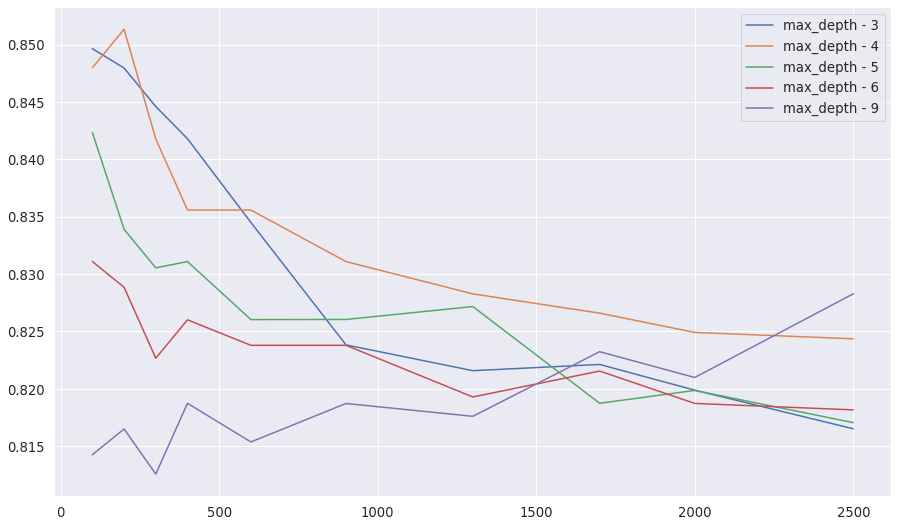

In [65]:
parameter_plot(GradientBoostingClassifier, X_train_fe, y_train, hyper_param=('max_depth', [3, 4, 5, 6, 9]))

max depth of 3 looks good

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished


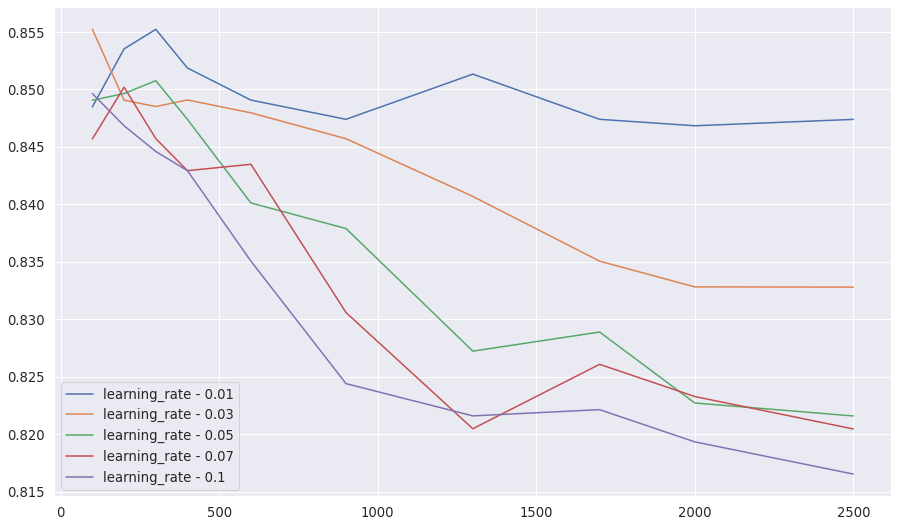

In [66]:
parameter_plot(GradientBoostingClassifier, X_train_fe, y_train, hyper_param=('learning_rate', [0.01, 0.03, 0.05, 0.07, 0.1]),
              max_depth=3)

lower learning rates are good!! lets test out small learning rates with a slightly higher one, we can see that as n_estiators increase the model starts to overfit and the accuracy goes down.

In [47]:
param_grid_gradient = {'max_depth':[3, 4],
                       'n_estimators':[300, 400, 500],
                       'learning_rate':[0.01, 0.03, 0.05],
                       'subsample':[0.5, 0.7],
                       'max_features':[0.5, 0.7],
                       #'min_samples_split':[2, 5, 8, 12]
                      }

In [68]:
grid_gradient = GridSearchCV(GradientBoostingClassifier(), param_grid_gradient, 
                        cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42),
                              scoring='accuracy', verbose=2, n_jobs=-1)

In [69]:
grid_gradient.fit(X_train_fe, y_train)

Fitting 20 folds for each of 72 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  6.1min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.05],
                         'max_depth': [3, 4], 'max_features': [0.5, 0.7],
                         'n_estimators': [300, 400, 500],
                         'subsample': [0.5, 0.7]},
             scoring='accuracy', verbose=2)

In [70]:
results(grid_gradient, n=60)

{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.7, 'n_estimators': 400, 'subsample': 0.7} : 0.854669163545568
{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 0.7, 'n_estimators': 300, 'subsample': 0.7} : 0.8524469413233458
{'learning_rate': 0.03, 'max_depth': 4, 'max_features': 0.7, 'n_estimators': 400, 'subsample': 0.7} : 0.8524406991260923
{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.5, 'n_estimators': 400, 'subsample': 0.5} : 0.852421972534332
{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 0.5, 'n_estimators': 400, 'subsample': 0.7} : 0.8513108614232209
{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.7, 'n_estimators': 500, 'subsample': 0.7} : 0.8513046192259676
{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.5, 'n_estimators': 500, 'subsample': 0.7} : 0.8512983770287142
{'learning_rate': 0.01, 'max_depth': 4, 'max_features': 0.7, 'n_estimators': 400, 'subsample': 0.5} : 0.8512983770287142
{'learning_rate': 0.01, 'max_depth

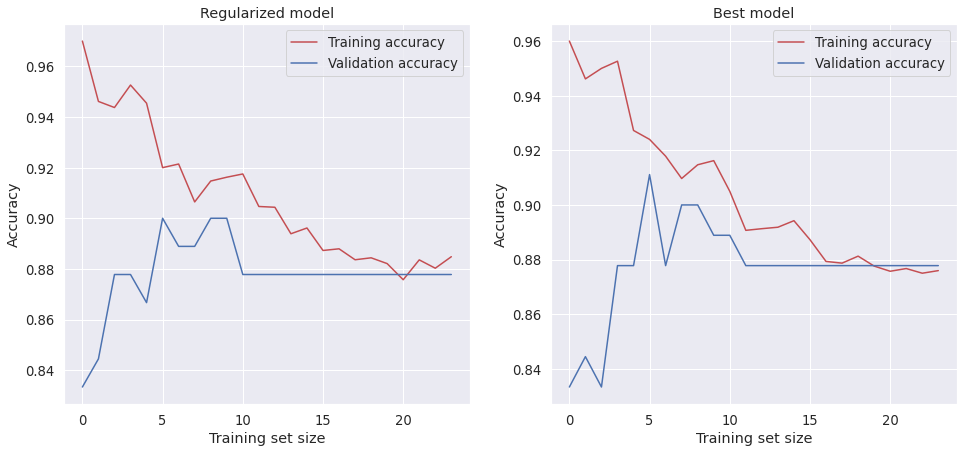

In [71]:
params_1 = ('Regularized model', {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.5, 
                                  'n_estimators': 500, 'subsample': 0.5})
params_2 = ('Best model', {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.7, 
                           'n_estimators': 400, 'subsample': 0.7})

learning_curve_plotter(GradientBoostingClassifier, X_train_fe, y_train, params_1, params_2, step=30)

In [67]:
params_gradient = {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 0.5, 'n_estimators': 500, 'subsample': 0.5}

### XGBClassifier

Fitting 20 folds for each of 40 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  4.5min finished


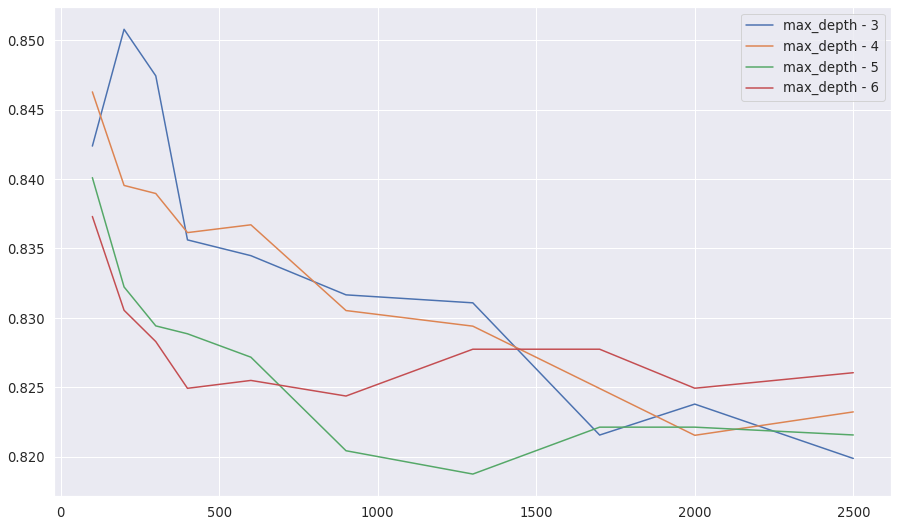

In [73]:
parameter_plot(XGBClassifier, X_train_fe, y_train, hyper_param=('max_depth', [3, 4, 5, 6]))

Fitting 20 folds for each of 50 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 401 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 684 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  5.2min finished


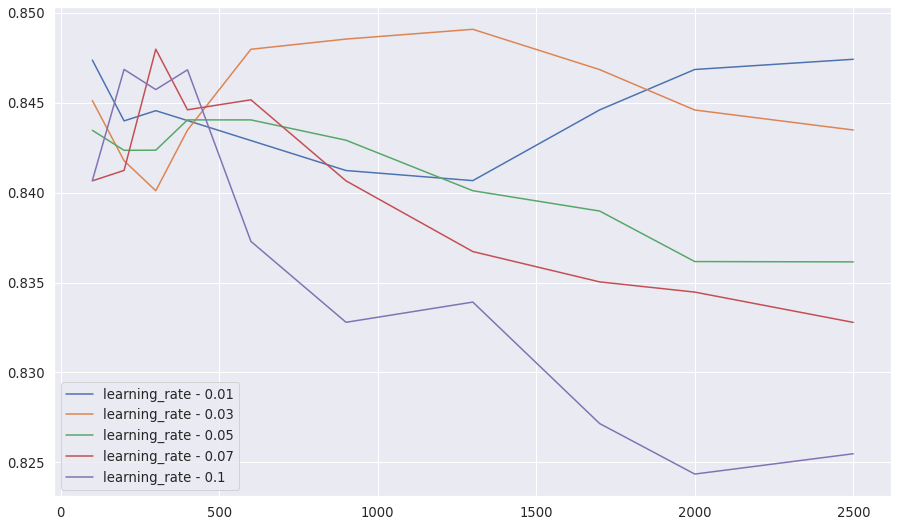

In [74]:
parameter_plot(XGBClassifier, X_train_fe, y_train, 
               hyper_param=('learning_rate', [0.01, 0.03, 0.05, 0.07, 0.1]), max_depth=4) 

In [46]:
param_grid_xgb = {'n_estimators':[400, 600],
                  'learning_rate':[0.01, 0.03, 0.05],
                  'max_depth':[3, 4],
                  'subsample':[0.5, 0.7],
                  'colsample_bylevel':[0.5, 0.7],
                  'reg_lambda':[15, None],
                 }

In [76]:
grid_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, 
                        cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42),
                              scoring='accuracy', verbose=2, n_jobs=-1)

In [77]:
grid_xgb.fit(X_train_fe, y_train)

Fitting 20 folds for each of 96 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  4.3min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=10, random_state=42),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=Non...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None)

In [78]:
results(grid_xgb, n=60)

{'colsample_bylevel': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 400, 'reg_lambda': None, 'subsample': 0.5} : 0.8580774032459427
{'colsample_bylevel': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 600, 'reg_lambda': 15, 'subsample': 0.7} : 0.8552746566791513
{'colsample_bylevel': 0.7, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 600, 'reg_lambda': 15, 'subsample': 0.5} : 0.8552621722846441
{'colsample_bylevel': 0.5, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 400, 'reg_lambda': 15, 'subsample': 0.7} : 0.8552434456928839
{'colsample_bylevel': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600, 'reg_lambda': 15, 'subsample': 0.5} : 0.8552247191011235
{'colsample_bylevel': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600, 'reg_lambda': 15, 'subsample': 0.5} : 0.8552247191011235
{'colsample_bylevel': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'reg_lambda': 15, 'subsample': 0.5} : 0.8546629

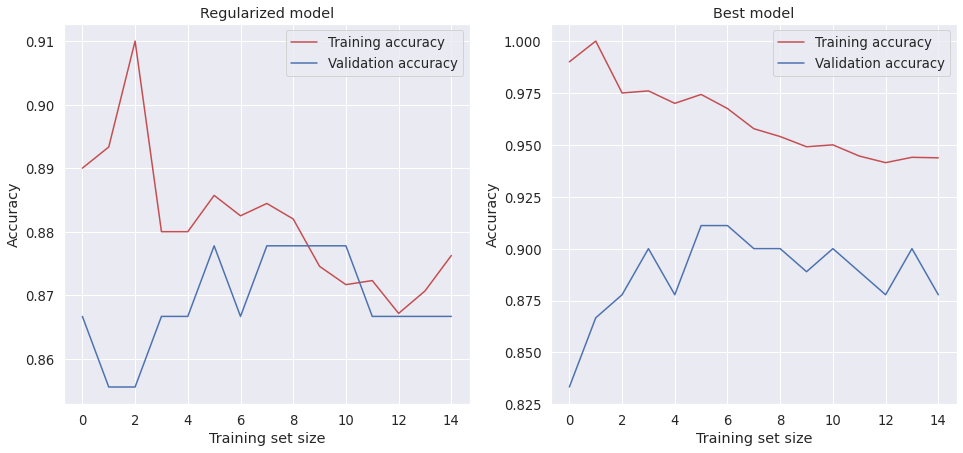

In [79]:
params_1 = ('Regularized model',{'colsample_bylevel': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 400,
                                 'reg_lambda': 15, 'subsample': 0.5})
params_2 = ('Best model', {'colsample_bylevel': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 600, 
                           'reg_lambda': None, 'subsample': 0.7} )

learning_curve_plotter(XGBClassifier, X_train_fe, y_train, params_1, params_2, step=50)

The reg_lambda : None, max_depth:4 and n_estimators:600 which are more than the regularized model are the features which are making the best model overfit the data.

In [68]:
params_xgb = {'colsample_bylevel': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 
              'n_estimators': 400, 'reg_lambda': 15, 'subsample': 0.5}

#### Lets summarize the way we just grid searched good parameters

* we first checked out our tree ensemble model's performance on the given dataset and then shortlisted range of max depths and n_estimators which are the mone of the most influential parameters.

* then we grid searched the shorlisted parameter values and with some other parameters such as max_samples and max_features, these parameters are must to search as they diversify our trees and make them less similar to each other.

* after we get the results, we then start searching the small parameter space near the optimal parameters obtained from gridsearch, we will usually see increase in accuracy for next few small gridsearchs this way.

* Check for overfitting and pick that model that has good accuracy with least overfitting...

# Stacking

In [81]:
logreg = LogisticRegression(**params_logreg)
svc = SVC(**params_svc)
knn = KNeighborsClassifier(**params_knn)
rfc = RandomForestClassifier(**params_random)
gradient = GradientBoostingClassifier(**params_gradient)
xgb = XGBClassifier(**params_xgb)

estimators = [('logreg', logreg), ('knn', knn), ('svc', svc), ('rfc', rfc), ('gradient', gradient), 
              ('xgb', xgb)]


stack = StackingClassifier(estimators=estimators,
                           cv=10, n_jobs=-1)

Stacking as above yielded 0.799 with survival rate and 0.784 without survival rate, an improvement of 0.145 from without survival rate feature... But i expected more and when i explored the individual model accuracy, i knew why i did not find many notebooks with survival rate feature and stacking...

* With survival rate : 0.799
* Without survival rate : 0.784

In [82]:
y_preds = logreg.fit(X_train_fe, y_train).predict(X_test_fe)

* With survival rate : 0.799
* Without survival rate : 0.787

In [83]:
y_preds = svc.fit(X_train_fe, y_train).predict(X_test_fe)

* With survival rate : 0.811
* Without survival rate : 0.7966

In [84]:
y_preds = knn.fit(X_train_fe, y_train).predict(X_test_fe)

* With survival rate : 0.806
* Without survival rate : 0.782

In [85]:
y_preds = rfc.fit(X_train_fe, y_train).predict(X_test_fe)

* With survival rate : 0.803
* Without survival rate : 0.7751

In [86]:
y_preds = gradient.fit(X_train_fe, y_train).predict(X_test_fe)

* With survival rate : 0.806
* Without survival rate : 0.7942

In [87]:
y_preds = xgb.fit(X_train_fe, y_train).predict(X_test_fe)

* With survival rate : 0.8133
* Without survival rate : 0.7918

In [88]:
submission = pd.DataFrame({'PassengerId':test.index, 
              'Survived':y_preds})

In [89]:
submission.to_csv('submission.csv', index=False)

In [90]:
pd.read_csv('submission.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


If found the kernel useful, upvote it !!  :)

If you have any suggestions please provide them in comment section.

## Fairness

In [54]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [55]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [56]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [57]:
##train['Sex'] = train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

X_train_fe['Survived'] = y_train
#X_train_fe = X_train_fe.drop(['Family_size_cat_small_family', 'Family_size_cat_large_family'], axis = 1)

#features = ["Pclass", "Sex", "SibSp", "Parch", "Survived"]
#X = pd.get_dummies(train_data[features])

In [58]:
X_train_fe

,Fare,Age_cat,Ticket_frequency,Ticket_extracted,Name_length,Family_Survival,Pclass_2,Pclass_3,Sex_male,Embarked_Q,...,Deck_DE,Deck_FG,Deck_M,Title_Miss.,Title_Mr.,Title_Mrs.,Title_rare,Family_size_cat_large_family,Family_size_cat_small_family,Survived
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,-0.502445,-0.974344,-0.624404,-2.351295,-0.451760,-0.060661,0,1,1,0,...,0,0,1,0,1,0,0,0,1,0
2,0.786845,1.419426,-0.067503,1.995293,2.580638,-0.060661,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
3,-0.488854,-0.176421,-0.624404,0.439840,-0.451760,-0.060661,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
4,0.420730,0.621503,-0.067503,-0.494295,1.657734,-1.604923,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
5,-0.486337,0.621503,-0.624404,-0.494295,-0.319916,-0.060661,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,-0.386671,-0.176421,-0.624404,-0.494295,-0.583603,-0.060661,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
888,-0.044381,-0.974344,-0.624404,-0.494295,0.207457,-0.060661,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
889,-0.176263,-0.974344,1.046299,-1.825563,1.394048,-1.604923,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0


In [59]:
privileged_groups = [{'Sex_male': 0}]
unprivileged_groups = [{'Sex_male': 1}]
dataset_orig = StandardDataset(X_train_fe,
                                  label_name='Survived',
                                  protected_attribute_names=['Sex_male'],
                                  favorable_classes=[1],
                                  privileged_classes=[[0]])

In [60]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.553130


In [8]:
data_orig_train = pd.read_pickle('../../Results/Stacking/6-titanic-complete-guide-to-top-3_Train.pkl')
data_orig_test = pd.read_pickle('../../Results/Stacking/6-titanic-complete-guide-to-top-3_Test.pkl')

In [69]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

import pickle

#data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()

logreg = LogisticRegression(**params_logreg)
svc = SVC(**params_svc)
knn = KNeighborsClassifier(**params_knn)
rfc = RandomForestClassifier(**params_random)
gradient = GradientBoostingClassifier(**params_gradient)
xgb = XGBClassifier(**params_xgb)

estimators = [('logreg', logreg), ('knn', knn), ('svc', svc), ('rfc', rfc), ('gradient', gradient), 
              ('xgb', xgb)]


model = StackingClassifier(estimators=estimators,
                           n_jobs=-1)

mdl = model.fit(X_train, y_train)
#with open('../../Results/Stacking/' + nb_fname + '.pkl', 'wb') as f:
#        pickle.dump(mdl, f)

#with open('../../Results/Stacking/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
#    pickle.dump(data_orig_train, f) 
    
#with open('../../Results/Stacking/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
#    pickle.dump(data_orig_test, f) 

In [70]:
final_metrics = []
accuracy = []
f1= []
from statistics import mean
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

for i in range(0,20):
    
    data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
    print(i)
    X_train = data_orig_train.features
    y_train = data_orig_train.labels.ravel()

    X_test = data_orig_test.features
    y_test = data_orig_test.labels.ravel()
    logreg = LogisticRegression(**params_logreg)
    svc = SVC(**params_svc)
    knn = KNeighborsClassifier(**params_knn)
    rfc = RandomForestClassifier(**params_random)
    gradient = GradientBoostingClassifier(**params_gradient)
    xgb = XGBClassifier(**params_xgb)

    estimators = [('logreg', logreg), ('knn', knn), ('svc', svc), ('rfc', rfc), ('gradient', gradient), 
                  ('xgb', xgb)]


    model = StackingClassifier(estimators=estimators,
                               n_jobs=-1)
  
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)

element_wise_std =  np.std(final_metrics, 0, ddof=1)
print("STD " + str(element_wise_std))
final_metrics = list(map(mean, zip(*final_metrics)))
accuracy = mean(accuracy)
f1 = mean(f1)
final_metrics[4] = np.log(final_metrics[4])
print(final_metrics)
print(sum(final_metrics[1:]))
print(accuracy)
print(f1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
STD [5.91607978 0.04065987 0.07569815 0.05263167 0.02528847 0.02189445]
[9.5, -0.7559046973815047, -0.6531737799059405, 0.523743823343295, -2.2941135138165047, 0.1162878297143423]
-3.0631603380463126
0.8544776119402985
0.7998280214649621


In [19]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
list_estimators = []
f1= []

for name, ml_model in estimators:
    
    list_estimators.append((name,ml_model))
    print(list_estimators)
    model = StackingClassifier(estimators = list_estimators)
    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)  
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


[('logreg', LogisticRegression(C=0.28, l1_ratio=0.9, penalty='elasticnet', solver='saga'))]
[('logreg', LogisticRegression(C=0.28, l1_ratio=0.9, penalty='elasticnet', solver='saga')), ('knn', KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=7))]
[('logreg', LogisticRegression(C=0.28, l1_ratio=0.9, penalty='elasticnet', solver='saga')), ('knn', KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=7)), ('svc', SVC(C=1, gamma=0.09, probability=True))]
[('logreg', LogisticRegression(C=0.28, l1_ratio=0.9, penalty='elasticnet', solver='saga')), ('knn', KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=7)), ('svc', SVC(C=1, gamma=0.09, probability=True)), ('rfc', RandomForestClassifier(max_depth=5, max_features=0.5, max_samples=0.9,
                       min_samples_split=8, n_estimators=300))]
[('logreg', LogisticRegression(C=0.28, l1_ratio=0.9, penalty='elasticnet', solver='saga')), ('knn', KNeighborsClassifier(algorithm='ball_tree', l

In [21]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
list_estimators = []
f1= []

for name, ml_model in estimators:
    
    list_estimators.append((name,ml_model))
    print(list_estimators)
    model = ml_model
    list_estimators = []

    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)  
    fair_list = fair.iloc[1].tolist()
    #fair_list.insert(0, i)
    final_metrics.append(fair_list)


[('logreg', LogisticRegression(C=0.28, l1_ratio=0.9, penalty='elasticnet', solver='saga'))]
[('knn', KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, n_neighbors=7))]
[('svc', SVC(C=1, gamma=0.09, probability=True))]
[('rfc', RandomForestClassifier(max_depth=5, max_features=0.5, max_samples=0.9,
                       min_samples_split=8, n_estimators=300))]
[('gradient', GradientBoostingClassifier(learning_rate=0.01, max_features=0.5,
                           n_estimators=500, subsample=0.5))]
[('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=15, scale_pos_

In [22]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
final_result[3] = np.log(final_result[3])
final_result = final_result.transpose()
acc_f1 = pd.DataFrame(accuracy)
acc_f1['f1'] = f1
acc_f1 = pd.DataFrame(acc_f1).transpose()
acc = acc_f1.rename(index={0: 'accuracy', 1: 'f1'})
final_result = final_result.rename(index={0: 'statistical_parity_difference', 1: 'equal_opportunity_difference', 2: 'average_abs_odds_difference', 3: 'disparate_impact', 4: 'theil_index'})
final_result = pd.concat([acc,final_result])
#final_result.columns = ['T' + str(col) for col in final_result.columns]
#final_result.insert(0, "classifier", final_result['T' + str(len(list_estimators) - 1)])   ##Add final metrics add the beginning of the df
#final_result.to_csv('../../Results/Stacking/' + nb_fname + '.csv')
final_result

,0,1,2,3,4,5
accuracy,0.854478,0.839552,0.869403,0.861940,0.869403,0.880597
f1,0.809756,0.781726,0.820513,0.810256,0.824121,0.841584
statistical_parity_difference,-0.731875,-0.667085,-0.775028,-0.726974,-0.719323,-0.717590
equal_opportunity_difference,-0.585506,-0.595228,-0.728237,-0.668582,-0.617764,-0.612903
average_abs_odds_difference,0.501783,0.445328,0.552803,0.496498,0.467466,0.442182
disparate_impact,-2.063248,-2.032299,-2.744274,-2.419320,-2.208755,-2.096015
theil_index,0.105421,0.128217,0.109524,0.114961,0.103741,0.091428
